# Mega Bar Plot
at the end of this notebook will be one bar plot that will contain experiments his585 and historical from three different models: ESM4, CM4 and CM4x compared to ERA5 data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
%matplotlib inline
%config InlineBackend.figure_format='retina'
import cmocean
import cartopy.crs as ccrs
import matplotlib.path as mpath
import nc_time_axis
import pandas as pd
import matplotlib as mpl
import momlevel as ml
import gcsfs
import zarr
from matplotlib.ticker import FormatStrFormatter
import cftime
import warnings

In [2]:
mask_CM4= xr.open_dataset('/home/pachamama/shared/antarctica_mask/CM4_mask_antarctica.nc')
mask_ESM4= xr.open_dataset('/home/pachamama/shared/antarctica_mask/ESM4_mask_antarctica.nc')
mask_ERA5= xr.open_dataset('/home/pachamama/shared/antarctica_mask/ERA5_mask_antarctica.nc')
mask_CM4X= xr.open_dataset('/home/pachamama/shared/antarctica_mask/CM4X_mask_antarctica.nc')

In [3]:
def standard_grid_cell_area(lat, lon, rE=6371.0e3):
    """ computes the cell area for a standard spherical grid """
    dLat = lat[1] - lat[0]
    dLon = lon[1] - lon[0]
    area = np.empty((len(lat), len(lon)))
    for j in range(0, len(lat)):
        for i in range(0, len(lon)):
            lon1 = lon[i] + dLon / 2
            lon0 = lon[i] - dLon / 2
            lat1 = lat[j] + dLat / 2
            lat0 = lat[j] - dLat / 2
            area[j, i] = (
                (np.pi / 180.0)
                * rE
                * rE
                * np.abs(np.sin(np.radians(lat0)) - np.sin(np.radians(lat1)))
                * np.abs(lon0 - lon1)
            )
    return area

# CM4x historical 

In [171]:
cm4x_uas=xr.open_mfdataset('/backup/tuq41374/model_output/cm4x/p25/historical/atmos/monthly/u_ref/*.nc')
cm4x_uas

<xarray.Dataset>
Dimensions:     (time: 1980, bnds: 2, lat: 360, lon: 576)
Coordinates:
  * bnds        (bnds) float64 1.0 2.0
  * lat         (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon         (lon) float64 0.3125 0.9375 1.562 2.188 ... 358.4 359.1 359.7
  * time        (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Data variables:
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(60,), meta=np.ndarray>
    average_T1  (time) datetime64[ns] dask.array<chunksize=(60,), meta=np.ndarray>
    average_T2  (time) datetime64[ns] dask.array<chunksize=(60,), meta=np.ndarray>
    lat_bnds    (time, lat, bnds) float64 dask.array<chunksize=(60, 360, 2), meta=np.ndarray>
    lon_bnds    (time, lon, bnds) float64 dask.array<chunksize=(60, 576, 2), meta=np.ndarray>
    time_bnds   (time, bnds) object dask.array<chunksize=(60, 2), meta=np.ndarray>
    u_ref       (time, lat, lon) float32 dask.array<chunksize=(60, 360, 576), meta=np.ndarray>
Attributes:
    filename:              atmos.185001-185412.u_ref.nc
    title:                 CM4_historical_c192_OM4p25
    associated_files:      area: 18540101.grid_spec.nc
    grid_type:             regular
    grid_tile:             N/A
    code_release_version:  19.1
    git_hash:              c97c1f6afab0df3545ee82c337d51accc4205bc3
    creationtime:          Sat Dec 24 23:27:31 2022
    hostname:              pp038
    history:               fregrid --standard_dimension --input_mosaic C192_m...

In [82]:
cm4x_vas=xr.open_mfdataset('/backup/tuq41374/model_output/cm4x/p25/historical/atmos/monthly/v_ref/*.nc')
cm4x_vas

<xarray.Dataset>
Dimensions:     (time: 1980, bnds: 2, lat: 360, lon: 576)
Coordinates:
  * bnds        (bnds) float64 1.0 2.0
  * lat         (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon         (lon) float64 0.3125 0.9375 1.562 2.188 ... 358.4 359.1 359.7
  * time        (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Data variables:
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(60,), meta=np.ndarray>
    average_T1  (time) datetime64[ns] dask.array<chunksize=(60,), meta=np.ndarray>
    average_T2  (time) datetime64[ns] dask.array<chunksize=(60,), meta=np.ndarray>
    lat_bnds    (time, lat, bnds) float64 dask.array<chunksize=(60, 360, 2), meta=np.ndarray>
    lon_bnds    (time, lon, bnds) float64 dask.array<chunksize=(60, 576, 2), meta=np.ndarray>
    time_bnds   (time, bnds) object dask.array<chunksize=(60, 2), meta=np.ndarray>
    v_ref       (time, lat, lon) float32 dask.array<chunksize=(60, 360, 576), meta=np.ndarray>
Attributes:
    filename:              atmos.185001-185412.v_ref.nc
    title:                 CM4_historical_c192_OM4p25
    associated_files:      area: 18540101.grid_spec.nc
    grid_type:             regular
    grid_tile:             N/A
    code_release_version:  19.1
    git_hash:              c97c1f6afab0df3545ee82c337d51accc4205bc3
    creationtime:          Sat Dec 24 23:27:31 2022
    hostname:              pp038
    history:               fregrid --standard_dimension --input_mosaic C192_m...

In [83]:
cm4x_uas_seasonal=cm4x_uas.u_ref.sel(time=slice('1995-01-16','2014-12-16')).groupby('time.season').mean(dim='time')
cm4x_uas_seasonal

<xarray.DataArray 'u_ref' (season: 4, lat: 360, lon: 576)>
dask.array<stack, shape=(4, 360, 576), dtype=float32, chunksize=(1, 360, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon      (lon) float64 0.3125 0.9375 1.562 2.188 ... 357.8 358.4 359.1 359.7
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    long_name:      zonal wind component at 10 m
    units:          m/s
    valid_range:    [-400.  400.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    interp_method:  conserve_order2

In [84]:
cm4x_vas_seasonal=cm4x_vas.v_ref.sel(time=slice('1995-01-16','2014-12-16')).groupby('time.season').mean(dim='time')
cm4x_vas_seasonal

<xarray.DataArray 'v_ref' (season: 4, lat: 360, lon: 576)>
dask.array<stack, shape=(4, 360, 576), dtype=float32, chunksize=(1, 360, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon      (lon) float64 0.3125 0.9375 1.562 2.188 ... 357.8 358.4 359.1 359.7
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    long_name:      meridional wind component at 10 m
    units:          m/s
    valid_range:    [-400.  400.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    interp_method:  conserve_order2

In [85]:
cm4x_vas_use=cm4x_vas.v_ref.sel(time=slice('1995-01-16','2014-12-16'))
cm4x_uas_use=cm4x_uas.u_ref.sel(time=slice('1995-01-16','2014-12-16'))

In [86]:
cm4x_his_mergewinds = xr.merge([cm4x_vas_use,cm4x_uas_use]) # merge winds to make it easy
cm4x_his_mergewinds_xmerge = cm4x_his_mergewinds.lon #extracting the lon component fomr the mergewinds array
cm4x_his_mergewinds_ymerge = cm4x_his_mergewinds.lat
cm4x_his_mergewinds_umerge = cm4x_his_mergewinds.u_ref 
cm4x_his_mergewinds_vmerge = cm4x_his_mergewinds.v_ref
cm4x_his_speedmerge = np.sqrt(np.square(cm4x_his_mergewinds_umerge) + np.square(cm4x_his_mergewinds_vmerge)) ## calculating speed using vector formula
## average
cm4x_his_timeaveragemerge = cm4x_his_speedmerge.sel(time=slice('1995-01-16','2014-12-16')).mean(dim='time')

In [87]:
cm4x_his_speedmerge

<xarray.DataArray (time: 240, lat: 360, lon: 576)>
dask.array<sqrt, shape=(240, 360, 576), dtype=float32, chunksize=(60, 360, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon      (lon) float64 0.3125 0.9375 1.562 2.188 ... 357.8 358.4 359.1 359.7
  * time     (time) object 1995-01-16 12:00:00 ... 2014-12-16 12:00:00

In [88]:
## merging the UAS seasonal and Vas seasonal to get merge seasonal
cm4x_his_seasonalmerge = xr.merge([cm4x_uas_seasonal,cm4x_vas_seasonal])
cm4x_his_seasonalmerge

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 576, season: 4)
Coordinates:
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon      (lon) float64 0.3125 0.9375 1.562 2.188 ... 357.8 358.4 359.1 359.7
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    u_ref    (season, lat, lon) float32 dask.array<chunksize=(1, 360, 576), meta=np.ndarray>
    v_ref    (season, lat, lon) float32 dask.array<chunksize=(1, 360, 576), meta=np.ndarray>
Attributes:
    long_name:      zonal wind component at 10 m
    units:          m/s
    valid_range:    [-400.  400.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    interp_method:  conserve_order2

In [89]:
## calculating the seasonal wind speed
cm4x_his_seasonal_speedmerge = np.sqrt(np.square(cm4x_his_seasonalmerge.u_ref) + np.square(cm4x_his_seasonalmerge.v_ref))

## slicing the summer speed
cm4x_his_Summer_szn_speed = cm4x_his_seasonal_speedmerge.sel(season=slice('DJF')).mean(dim='season')
## Slicing summer season from seasonalmerge
cm4x_his_Summer_szn= cm4x_his_seasonalmerge.sel(season='DJF')

## slicing seasonalspeed to get speed for winter and averaging it
cm4x_his_Winter_szn_speed = cm4x_his_seasonal_speedmerge.sel(season=slice('JJA')).mean(dim='season')
cm4x_his_Winter_szn= cm4x_his_seasonalmerge.sel(season='JJA')

## FALL seasonal speed merge and averaging
cm4x_his_Fall_szn_speed = cm4x_his_seasonal_speedmerge.sel(season=slice('MAM')).mean(dim='season')
cm4x_his_Fall_szn= cm4x_his_seasonalmerge.sel(season='MAM')

## slicing seasonalspeed to get spring values and averaging it
cm4x_his_Spring_szn_speed = cm4x_his_seasonal_speedmerge.sel(season=slice('SON')).mean(dim='season')
cm4x_his_Spring_szn= cm4x_his_seasonalmerge.sel(season='SON')

In [90]:
lat_CM4x_historical = cm4x_his_speedmerge.coords['lat'].values #1-D numpy array of model's latitude values
lon_CM4x_historical = cm4x_his_speedmerge.coords['lon'].values #1-D numpy array of model's longitude values
# make sure to replace the name of the data array if you chose a
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.
# Pass the arrays to the standard_grid_cell_area function
areacell = standard_grid_cell_area(lat_CM4x_historical,lon_CM4x_historical)

# The areacella_xarray function outputs a numpy array. Convert this back into
# and xarray DataArray for further use. If this is a field you will be using
# often. You may wish to save this newly created DataArray as a Dataset and save
# as a netcdf file.
# here we assign dimensions and coordinates that are the same as our original SST array:
areacell_CM4x_historical = xr.DataArray(areacell,dims=({'lat':180, 'lon':360}),\
                                                coords=(cm4x_his_speedmerge.coords['lat'],\
                                                        cm4x_his_speedmerge.coords['lon']))

In [91]:
weights_cm4x=areacell_CM4x_historical

In [92]:
weight_ross_CM4x_historical=(mask_CM4X.ross_CM4X*cm4x_his_speedmerge).weighted(weights_cm4x).mean(dim=['lat','lon'])
weight_filchner_CM4x_historical=(mask_CM4X.filchner_CM4X*cm4x_his_speedmerge).weighted(weights_cm4x).mean(dim=['lat','lon'])
weight_peninsula_CM4x_historical= (mask_CM4X.peninsula_CM4X*cm4x_his_speedmerge).weighted(weights_cm4x).mean(dim=['lat','lon'])
weight_loweast_CM4x_historical= (mask_CM4X.loweast_CM4X*cm4x_his_speedmerge).weighted(weights_cm4x).mean(dim=['lat','lon'])
weight_lowwest_CM4x_historical= (mask_CM4X.lowwest_CM4X*cm4x_his_speedmerge).weighted(weights_cm4x).mean(dim=['lat','lon'])
weight_plateau_CM4x_historical= (mask_CM4X.plateau_CM4X*cm4x_his_speedmerge).weighted(weights_cm4x).mean(dim=['lat','lon'])

In [93]:
weight_ross_cm4x_annual_historical = ml.util.annual_average(weight_ross_CM4x_historical,tcoord='time')
weight_filchner_cm4x_annual_historical= ml.util.annual_average(weight_filchner_CM4x_historical, tcoord='time')
weight_peninsula_cm4x_annual_historical=ml.util.annual_average(weight_peninsula_CM4x_historical, tcoord='time')
weight_loweast_cm4x_annual_historical=ml.util.annual_average(weight_loweast_CM4x_historical, tcoord='time')
weight_lowwest_cm4x_annual_historical=ml.util.annual_average(weight_lowwest_CM4x_historical, tcoord='time')
weight_plateau_cm4x_annual_historical=ml.util.annual_average(weight_plateau_CM4x_historical, tcoord='time')

In [94]:
cm4x_his_ross_wind=weight_ross_cm4x_annual_historical.mean(dim='time')
cm4x_his_filch_wind=weight_filchner_cm4x_annual_historical.mean(dim='time')
cm4x_his_pen_wind=weight_peninsula_cm4x_annual_historical.mean(dim='time')
cm4x_his_east_wind=weight_loweast_cm4x_annual_historical.mean(dim='time')
cm4x_his_west_wind=weight_lowwest_cm4x_annual_historical.mean(dim='time')
cm4x_his_plat_wind=weight_plateau_cm4x_annual_historical.mean(dim='time')

In [95]:
print(cm4x_his_ross_wind.values)
print(cm4x_his_filch_wind.values)
print(cm4x_his_pen_wind.values)
print(cm4x_his_east_wind.values)
print(cm4x_his_west_wind.values)
print(cm4x_his_plat_wind.values)

2.795495161565733
2.4551558437181096
3.046842730252119
5.91763074811499
4.067977060422126
4.6643710997910235


In [96]:
ross_total_std_CM4x= weight_ross_cm4x_annual_historical.std('time')
filchner_total_std_CM4x= weight_filchner_cm4x_annual_historical.std('time')
peninsula_total_std_CM4x=weight_peninsula_cm4x_annual_historical.std('time')
loweast_total_std_CM4x=weight_loweast_cm4x_annual_historical.std('time')
lowwest_total_std_CM4x=weight_lowwest_cm4x_annual_historical.std('time')
plateau_total_std_CM4x=weight_plateau_cm4x_annual_historical.std('time')

In [97]:
print(ross_total_std_CM4x.values)
print(filchner_total_std_CM4x.values)
print(peninsula_total_std_CM4x.values)
print(loweast_total_std_CM4x.values)
print(lowwest_total_std_CM4x.values)
print(plateau_total_std_CM4x.values)

0.08563159452774731
0.09880345534111222
0.11616729623324284
0.04899005280025134
0.06580244510510012
0.06702133318191811


In [98]:
ross_total_CM4X_his= weight_ross_CM4x_historical.mean('time')
filchner_total_CM4X_his=weight_filchner_CM4x_historical.mean('time')
peninsula_total_CM4X_his=weight_peninsula_CM4x_historical.mean('time')
loweast_total_CM4X_his=weight_loweast_CM4x_historical.mean('time')
lowwest_total_CM4X_his=weight_lowwest_CM4x_historical.mean('time')
plateau_total_CM4X_his=weight_plateau_CM4x_historical.mean('time')

In [99]:
ross_total_val_CM4X_his= print(ross_total_CM4X_his.values)
filchner_total_val_CM4X_his=print(filchner_total_CM4X_his.values)
peninsula_total_val_CM4X_his=print(peninsula_total_CM4X_his.values)
loweast_total_val_CM4X_his=print(loweast_total_CM4X_his.values)
lowwest_total_val_CM4X_his=print(lowwest_total_CM4X_his.values)
plateau_total_val_CM4X_his=print(plateau_total_CM4X_his.values)

2.7948578072203487
2.4545504671235236
3.046108256536738
5.913807171022635
4.066487088117113
4.661868222546543


# CM4x SSP585

In [100]:
cm4x_uas_ssp585=xr.open_mfdataset('/backup/tuq41374/model_output/cm4x/p25/ssp585/atmos/monthly/u_ref/*.nc')
cm4x_uas_ssp585

<xarray.Dataset>
Dimensions:     (time: 1020, bnds: 2, lat: 360, lon: 576)
Coordinates:
  * bnds        (bnds) float64 1.0 2.0
  * lat         (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon         (lon) float64 0.3125 0.9375 1.562 2.188 ... 358.4 359.1 359.7
  * time        (time) object 2015-01-16 12:00:00 ... 2099-12-16 12:00:00
Data variables:
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(60,), meta=np.ndarray>
    average_T1  (time) datetime64[ns] dask.array<chunksize=(60,), meta=np.ndarray>
    average_T2  (time) datetime64[ns] dask.array<chunksize=(60,), meta=np.ndarray>
    lat_bnds    (time, lat, bnds) float64 dask.array<chunksize=(60, 360, 2), meta=np.ndarray>
    lon_bnds    (time, lon, bnds) float64 dask.array<chunksize=(60, 576, 2), meta=np.ndarray>
    time_bnds   (time, bnds) object dask.array<chunksize=(60, 2), meta=np.ndarray>
    u_ref       (time, lat, lon) float32 dask.array<chunksize=(60, 360, 576), meta=np.ndarray>
Attributes:
    filename:              atmos.201501-201912.u_ref.nc
    title:                 CM4_ssp585_c192_OM4p25
    associated_files:      area: 20190101.grid_spec.nc
    grid_type:             regular
    grid_tile:             N/A
    code_release_version:  19.1
    git_hash:              c97c1f6afab0df3545ee82c337d51accc4205bc3
    creationtime:          Thu Feb 16 13:17:56 2023
    hostname:              pp033
    history:               fregrid --standard_dimension --input_mosaic C192_m...

In [101]:
cm4x_vas_ssp585=xr.open_mfdataset('/backup/tuq41374/model_output/cm4x/p25/ssp585/atmos/monthly/v_ref/*.nc')
cm4x_vas_ssp585

<xarray.Dataset>
Dimensions:     (time: 1020, bnds: 2, lat: 360, lon: 576)
Coordinates:
  * bnds        (bnds) float64 1.0 2.0
  * lat         (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon         (lon) float64 0.3125 0.9375 1.562 2.188 ... 358.4 359.1 359.7
  * time        (time) object 2015-01-16 12:00:00 ... 2099-12-16 12:00:00
Data variables:
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(60,), meta=np.ndarray>
    average_T1  (time) datetime64[ns] dask.array<chunksize=(60,), meta=np.ndarray>
    average_T2  (time) datetime64[ns] dask.array<chunksize=(60,), meta=np.ndarray>
    lat_bnds    (time, lat, bnds) float64 dask.array<chunksize=(60, 360, 2), meta=np.ndarray>
    lon_bnds    (time, lon, bnds) float64 dask.array<chunksize=(60, 576, 2), meta=np.ndarray>
    time_bnds   (time, bnds) object dask.array<chunksize=(60, 2), meta=np.ndarray>
    v_ref       (time, lat, lon) float32 dask.array<chunksize=(60, 360, 576), meta=np.ndarray>
Attributes:
    filename:              atmos.201501-201912.v_ref.nc
    title:                 CM4_ssp585_c192_OM4p25
    associated_files:      area: 20190101.grid_spec.nc
    grid_type:             regular
    grid_tile:             N/A
    code_release_version:  19.1
    git_hash:              c97c1f6afab0df3545ee82c337d51accc4205bc3
    creationtime:          Thu Feb 16 13:17:56 2023
    hostname:              pp033
    history:               fregrid --standard_dimension --input_mosaic C192_m...

In [102]:
cm4x_uas_ssp_seasonal=cm4x_uas_ssp585.u_ref.sel(time=slice('2081-01-16', '2100-12-16')).groupby('time.season').mean(dim='time')
cm4x_vas_ssp_seasonal=cm4x_vas_ssp585.v_ref.sel(time=slice('2081-01-16', '2100-12-16')).groupby('time.season').mean(dim='time')
cm4x_vas_ssp_seasonal

<xarray.DataArray 'v_ref' (season: 4, lat: 360, lon: 576)>
dask.array<stack, shape=(4, 360, 576), dtype=float32, chunksize=(1, 360, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon      (lon) float64 0.3125 0.9375 1.562 2.188 ... 357.8 358.4 359.1 359.7
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    long_name:      meridional wind component at 10 m
    units:          m/s
    valid_range:    [-400.  400.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    interp_method:  conserve_order2

In [103]:
cm4x_ssp_uas_use=cm4x_uas_ssp585.sel(time=slice('2081-01-16', '2100-12-16'))
cm4x_ssp_vas_use=cm4x_vas_ssp585.sel(time=slice('2081-01-16', '2100-12-16'))

In [104]:
cm4x_ssp_mergewinds = xr.merge([cm4x_ssp_uas_use,cm4x_ssp_vas_use]) # merge winds to make it easy
cm4x_ssp_mergewinds_xmerge = cm4x_ssp_mergewinds.lon #extracting the lon component fomr the mergewinds array
cm4x_ssp_mergewinds_ymerge = cm4x_ssp_mergewinds.lat
cm4x_ssp_mergewinds_umerge = cm4x_ssp_mergewinds.u_ref 
cm4x_ssp_mergewinds_vmerge = cm4x_ssp_mergewinds.v_ref
cm4x_ssp_speedmerge = np.sqrt(np.square(cm4x_ssp_mergewinds_umerge) + np.square(cm4x_ssp_mergewinds_vmerge)) ## calculating speed using vector formula
## average
cm4x_ssp_timeaveragemerge = cm4x_ssp_speedmerge.sel(time=slice('2081-01-16', '2100-12-16')).mean(dim='time')

In [105]:
cm4x_ssp_speedmerge

<xarray.DataArray (time: 228, lat: 360, lon: 576)>
dask.array<sqrt, shape=(228, 360, 576), dtype=float32, chunksize=(60, 360, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon      (lon) float64 0.3125 0.9375 1.562 2.188 ... 357.8 358.4 359.1 359.7
  * time     (time) object 2081-01-16 12:00:00 ... 2099-12-16 12:00:00

In [106]:
cm4x_ssp_seasonal_merge=xr.merge([cm4x_uas_ssp_seasonal,cm4x_vas_ssp_seasonal])
cm4x_ssp_seasonal_merge

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 576, season: 4)
Coordinates:
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon      (lon) float64 0.3125 0.9375 1.562 2.188 ... 357.8 358.4 359.1 359.7
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    u_ref    (season, lat, lon) float32 dask.array<chunksize=(1, 360, 576), meta=np.ndarray>
    v_ref    (season, lat, lon) float32 dask.array<chunksize=(1, 360, 576), meta=np.ndarray>
Attributes:
    long_name:      zonal wind component at 10 m
    units:          m/s
    valid_range:    [-400.  400.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    interp_method:  conserve_order2

In [107]:
## calculating the seasonal wind speed
cm4x_ssp_seasonal_speedmerge = np.sqrt(np.square(cm4x_ssp_seasonal_merge.u_ref) + np.square(cm4x_ssp_seasonal_merge.v_ref))

## slicing the summer speed
cm4x_ssp_Summer_szn_speed = cm4x_ssp_seasonal_speedmerge.sel(season=slice('DJF')).mean(dim='season')
## Slicing summer season from seasonalmerge
cm4x_ssp_Summer_szn= cm4x_ssp_seasonal_merge.sel(season='DJF')

## slicing seasonalspeed to get speed for winter and averaging it
cm4x_ssp_Winter_szn_speed = cm4x_ssp_seasonal_speedmerge.sel(season=slice('JJA')).mean(dim='season')
cm4x_ssp_Winter_szn= cm4x_ssp_seasonal_merge.sel(season='JJA')

## FALL seasonal speed merge and averaging
cm4x_ssp_Fall_szn_speed = cm4x_ssp_seasonal_speedmerge.sel(season=slice('MAM')).mean(dim='season')
cm4x_ssp_Fall_szn= cm4x_ssp_seasonal_merge.sel(season='MAM')

## slicing seasonalspeed to get spring values and averaging it
cm4x_ssp_Spring_szn_speed = cm4x_ssp_seasonal_speedmerge.sel(season=slice('SON')).mean(dim='season')
cm4x_ssp_Spring_szn= cm4x_ssp_seasonal_merge.sel(season='SON')

In [108]:
lat_CM4x_ssp = cm4x_ssp_speedmerge.coords['lat'].values #1-D numpy array of model's latitude values
lon_CM4x_ssp = cm4x_ssp_speedmerge.coords['lon'].values #1-D numpy array of model's longitude values
# make sure to replace the name of the data array if you chose a
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.
# Pass the arrays to the standard_grid_cell_area function
areacell = standard_grid_cell_area(lat_CM4x_ssp,lon_CM4x_ssp)

# The areacella_xarray function outputs a numpy array. Convert this back into
# and xarray DataArray for further use. If this is a field you will be using
# often. You may wish to save this newly created DataArray as a Dataset and save
# as a netcdf file.
# here we assign dimensions and coordinates that are the same as our original SST array:
areacell_CM4x_ssp = xr.DataArray(areacell,dims=({'lat':180, 'lon':360}),\
                                                coords=(cm4x_ssp_speedmerge.coords['lat'],\
                                                        cm4x_ssp_speedmerge.coords['lon']))

In [109]:
ssp_weights_cm4x=areacell_CM4x_ssp

In [110]:
weight_ross_CM4x_ssp=(mask_CM4X.ross_CM4X*cm4x_ssp_speedmerge).weighted(ssp_weights_cm4x).mean(dim=['lat','lon'])
weight_filchner_CM4x_ssp=(mask_CM4X.filchner_CM4X*cm4x_ssp_speedmerge).weighted(ssp_weights_cm4x).mean(dim=['lat','lon'])
weight_peninsula_CM4x_ssp= (mask_CM4X.peninsula_CM4X*cm4x_ssp_speedmerge).weighted(ssp_weights_cm4x).mean(dim=['lat','lon'])
weight_loweast_CM4x_ssp= (mask_CM4X.loweast_CM4X*cm4x_ssp_speedmerge).weighted(ssp_weights_cm4x).mean(dim=['lat','lon'])
weight_lowwest_CM4x_ssp= (mask_CM4X.lowwest_CM4X*cm4x_ssp_speedmerge).weighted(ssp_weights_cm4x).mean(dim=['lat','lon'])
weight_plateau_CM4x_ssp= (mask_CM4X.plateau_CM4X*cm4x_ssp_speedmerge).weighted(ssp_weights_cm4x).mean(dim=['lat','lon'])

In [111]:
weight_ross_cm4x_annual_ssp = ml.util.annual_average(weight_ross_CM4x_ssp,tcoord='time')
weight_filchner_cm4x_annual_ssp= ml.util.annual_average(weight_filchner_CM4x_ssp, tcoord='time')
weight_peninsula_cm4x_annual_ssp=ml.util.annual_average(weight_peninsula_CM4x_ssp, tcoord='time')
weight_loweast_cm4x_annual_ssp=ml.util.annual_average(weight_loweast_CM4x_ssp, tcoord='time')
weight_lowwest_cm4x_annual_ssp=ml.util.annual_average(weight_lowwest_CM4x_ssp, tcoord='time')
weight_plateau_cm4x_annual_ssp=ml.util.annual_average(weight_plateau_CM4x_ssp, tcoord='time')

In [112]:
cm4x_ssp_ross_wind=weight_ross_cm4x_annual_ssp.mean(dim='time')
cm4x_ssp_filch_wind=weight_filchner_cm4x_annual_ssp.mean(dim='time')
cm4x_ssp_pen_wind=weight_peninsula_cm4x_annual_ssp.mean(dim='time')
cm4x_ssp_east_wind=weight_loweast_cm4x_annual_ssp.mean(dim='time')
cm4x_ssp_west_wind=weight_lowwest_cm4x_annual_ssp.mean(dim='time')
cm4x_ssp_plat_wind=weight_plateau_cm4x_annual_ssp.mean(dim='time')

In [113]:
print(cm4x_ssp_ross_wind.values)
print(cm4x_ssp_filch_wind.values)
print(cm4x_ssp_pen_wind.values)
print(cm4x_ssp_east_wind.values)
print(cm4x_ssp_west_wind.values)
print(cm4x_ssp_plat_wind.values)

2.6883911524608126
2.4005182851131757
3.011193493951181
5.726419567260154
3.954811912334859
4.571322007188408


In [114]:
ross_total_std_CM4x_ssp= weight_ross_cm4x_annual_ssp.std('time')
filchner_total_std_CM4x_ssp= weight_filchner_cm4x_annual_ssp.std('time')
peninsula_total_std_CM4x_ssp=weight_peninsula_cm4x_annual_ssp.std('time')
loweast_total_std_CM4x_ssp=weight_loweast_cm4x_annual_ssp.std('time')
lowwest_total_std_CM4x_ssp=weight_lowwest_cm4x_annual_ssp.std('time')
plateau_total_std_CM4x_ssp=weight_plateau_cm4x_annual_ssp.std('time')

In [115]:
print(ross_total_std_CM4x_ssp.values)
print(filchner_total_std_CM4x_ssp.values)
print(peninsula_total_std_CM4x_ssp.values)
print(loweast_total_std_CM4x_ssp.values)
print(lowwest_total_std_CM4x_ssp.values)
print(plateau_total_std_CM4x_ssp.values)

0.12284717596089571
0.08617890230707151
0.20461534667324466
0.07259554082602682
0.09949711868152591
0.06288855821790354


# ESM4 historical 

In [116]:
esm4 = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
#defines the Eastward Near-Surface Wind
gfdl_esm4_uas_data = esm4.query(
    "table_id == 'Amon' & \
    variable_id == 'uas' & \
    experiment_id == 'historical' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4'")

gcs = gcsfs.GCSFileSystem(token='anon')
zstore_esm4_uas = gfdl_esm4_uas_data.zstore.values[-1]
mapper_esm4_uas = gcs.get_mapper(zstore_esm4_uas)

esm4_uas = xr.open_zarr(mapper_esm4_uas, 
                                consolidated=True,use_cftime=True)

#defines the NorthWard Near-Surface Wind
gfdl_esm4_vas_data = esm4.query(
    "table_id == 'Amon' & \
    variable_id == 'vas' & \
    experiment_id == 'historical' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4'")

zstore_esm4_vas = gfdl_esm4_vas_data.zstore.values[-1]
mapper_esm4_vas = gcs.get_mapper(zstore_esm4_vas)

esm4_vas = xr.open_zarr(mapper_esm4_vas, 
                                consolidated=True,use_cftime=True)

In [117]:
esm4_vas

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lon: 288, time: 1980)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
    height     float64 ...
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Data variables:
    vas        (time, lat, lon) float32 dask.array<chunksize=(596, 180, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  36500.0
    comment:                <null ref>
    ...                     ...
    tracking_id:            hdl:21.14100/39b6212a-af33-4131-b50b-7b10c22594ab...
    variable_id:            vas
    variant_info:           N/A
    variant_label:          r1i1p1f1
    netcdf_tracking_ids:    hdl:21.14100/39b6212a-af33-4131-b50b-7b10c22594ab...
    version_id:             v20190726

In [118]:
uase4=esm4_uas.uas.sel(time=slice('1995-01-16','2014-12-16')) #eastward wind variable
## grouping the data into seasons and averaging the seasons
ESM4_uas_seasonal = uase4.groupby('time.season').mean(dim='time')
ESM4_uas_seasonal

## Slicing the eastward wind into the south pole region
vase4 = esm4_vas.vas.sel(time=slice('1995-01-16','2014-12-16')) #northward wind variable
## grouping the data into seasons and averaging the 500 seasons
ESM4_vas_seasonal = vase4.groupby('time.season').mean(dim='time')
ESM4_vas_seasonal

<xarray.DataArray 'vas' (season: 4, lat: 180, lon: 288)>
dask.array<stack, shape=(4, 180, 288), dtype=float32, chunksize=(1, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Northward Near-Surface Wind
    original_name:  vas
    standard_name:  northward_wind
    units:          m s-1

In [119]:
mergedwindse4 = xr.merge([uase4,vase4])
esm4_xmerge=mergedwindse4.lon
esm4_ymerge=mergedwindse4.lat
esm4_umerge=mergedwindse4.uas
esm4_vmerge=mergedwindse4.vas
esm4_speed_merge=np.sqrt(np.square(esm4_umerge) + np.square(esm4_vmerge))
esm4_speed_merge
#wind speed around antarctica 

esm4_timeaveragemerge = mergedwindse4.sel(time=slice('1995-01-16','2014-12-16')).mean(dim='time')
esm4_timeaveragemerge

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 288)
Coordinates:
    height   float64 10.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
Data variables:
    uas      (lat, lon) float32 dask.array<chunksize=(180, 288), meta=np.ndarray>
    vas      (lat, lon) float32 dask.array<chunksize=(180, 288), meta=np.ndarray>

In [120]:
ESM4_speedslice = esm4_speed_merge.mean(dim='time')
ESM4_speedslice

<xarray.DataArray (lat: 180, lon: 288)>
dask.array<mean_agg-aggregate, shape=(180, 288), dtype=float32, chunksize=(180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 10.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4

In [121]:
#ESM4_vas_seasonal defined earlier
## merging the UAS seasonal and Vas seasonal to get merge seasonal
esm4_seasonalmerge= xr.merge([ESM4_uas_seasonal,ESM4_vas_seasonal])

##
## calculating the seasonal wind speed
esm4_SPEED_seasonalmerge = np.sqrt(np.square(esm4_seasonalmerge.uas) + np.square(esm4_seasonalmerge.vas))


In [122]:
## slicing the summer speed
ESM4_Summer_szn_speed = esm4_SPEED_seasonalmerge.sel(season=slice('DJF')).mean(dim='season')
## Slicing summer season from seasonalmerge
ESM4_Summer_szn= esm4_seasonalmerge.sel(season='DJF') #MUST USE SEASONAL MERGE NOT SPEED SEASONAL MERGE. BE CAREFUL

## slicing the winter speed
ESM4_winter_szn_speed = esm4_SPEED_seasonalmerge.sel(season=slice('JJA')).mean(dim='season')
## Slicing winter season from seasonalmerge
ESM4_winter_szn= esm4_seasonalmerge.sel(season='JJA') #MUST USE SEASONAL MERGE NOT SPEED SEASONAL MERGE. BE CAREFUL

## slicing the fall speed
ESM4_fall_szn_speed = esm4_SPEED_seasonalmerge.sel(season=slice('MAM')).mean(dim='season')
## Slicing fall season from seasonalmerge
ESM4_fall_szn= esm4_seasonalmerge.sel(season='MAM') #MUST USE SEASONAL MERGE NOT SPEED SEASONAL MERGE. BE CAREFUL

## slicing the spring speed
ESM4_spring_szn_speed = esm4_SPEED_seasonalmerge.sel(season=slice('SON')).mean(dim='season')
## Slicing spring season from seasonalmerge
ESM4_spring_szn= esm4_seasonalmerge.sel(season='SON') #MUST USE SEASONAL MERGE NOT SPEED SEASONAL MERGE. BE CAREFUL

In [123]:
lat_esm4_historical = esm4_speed_merge.coords['lat'].values #1-D numpy array of model's latitude values
lon_esm4_historical = esm4_speed_merge.coords['lon'].values #1-D numpy array of model's longitude values
# make sure to replace the name of the data array if you chose a
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.
# Pass the arrays to the standard_grid_cell_area function
esm4_his_areacell = standard_grid_cell_area(lat_esm4_historical,lon_esm4_historical)

# The areacella_xarray function outputs a numpy array. Convert this back into
# and xarray DataArray for further use. If this is a field you will be using
# often. You may wish to save this newly created DataArray as a Dataset and save
# as a netcdf file.
# here we assign dimensions and coordinates that are the same as our original SST array:
areacell_esm4_historical = xr.DataArray(esm4_his_areacell,dims=({'lat':180, 'lon':360}),\
                                                coords=(esm4_speed_merge.coords['lat'],\
                                                        esm4_speed_merge.coords['lon']))

In [124]:
weights_esm4_his=areacell_esm4_historical

In [125]:
weight_ross_ESM4_historical=(mask_ESM4.ross_ESM4*esm4_speed_merge).weighted(weights_esm4_his).mean(dim=['lat','lon'])
weight_filchner_ESM4_historical=(mask_ESM4.filchner_ESM4*esm4_speed_merge).weighted(weights_esm4_his).mean(dim=['lat','lon'])
weight_peninsula_ESM4_historical= (mask_ESM4.peninsula_ESM4*esm4_speed_merge).weighted(weights_esm4_his).mean(dim=['lat','lon'])
weight_loweast_ESM4_historical= (mask_ESM4.loweast_ESM4*esm4_speed_merge).weighted(weights_esm4_his).mean(dim=['lat','lon'])
weight_lowwest_ESM4_historical= (mask_ESM4.lowwest_ESM4*esm4_speed_merge).weighted(weights_esm4_his).mean(dim=['lat','lon'])
weight_plateau_ESM4_historical= (mask_ESM4.plateau_ESM4*esm4_speed_merge).weighted(weights_esm4_his).mean(dim=['lat','lon'])

In [126]:
weight_ross_ESM4_annual_historical = ml.util.annual_average(weight_ross_ESM4_historical,tcoord='time')
weight_filchner_ESM4_annual_historical= ml.util.annual_average(weight_filchner_ESM4_historical, tcoord='time')
weight_peninsula_ESM4_annual_historical=ml.util.annual_average(weight_peninsula_ESM4_historical, tcoord='time')
weight_loweast_ESM4_annual_historical=ml.util.annual_average(weight_loweast_ESM4_historical, tcoord='time')
weight_lowwest_ESM4_annual_historical=ml.util.annual_average(weight_lowwest_ESM4_historical, tcoord='time')
weight_plateau_ESM4_annual_historical=ml.util.annual_average(weight_plateau_ESM4_historical, tcoord='time')

In [127]:
ESM4_historical_ross_wind=weight_ross_ESM4_annual_historical.mean(dim='time')
ESM4_historical_filch_wind=weight_filchner_ESM4_annual_historical.mean(dim='time')
ESM4_historical_pen_wind=weight_peninsula_ESM4_annual_historical.mean(dim='time')
ESM4_historical_east_wind=weight_loweast_ESM4_annual_historical.mean(dim='time')
ESM4_historical_west_wind=weight_lowwest_ESM4_annual_historical.mean(dim='time')
ESM4_historical_plat_wind=weight_plateau_ESM4_annual_historical.mean(dim='time')

In [128]:
print(ESM4_historical_ross_wind.values)
print(ESM4_historical_filch_wind.values)
print(ESM4_historical_pen_wind.values)
print(ESM4_historical_east_wind.values)
print(ESM4_historical_west_wind.values)
print(ESM4_historical_plat_wind.values)

2.717323193980317
2.413653711220919
3.2008522669365895
6.944507789949228
4.556693396811866
4.876263966612993


In [129]:
ross_total_std_ESM4= weight_ross_ESM4_annual_historical.std('time')
filchner_total_std_ESM4= weight_filchner_ESM4_annual_historical.std('time')
peninsula_total_std_ESM4=weight_peninsula_ESM4_annual_historical.std('time')
loweast_total_std_ESM4=weight_loweast_ESM4_annual_historical.std('time')
lowwest_total_std_ESM4=weight_lowwest_ESM4_annual_historical.std('time')
plateau_total_std_ESM4=weight_plateau_ESM4_annual_historical.std('time')

In [130]:
print(ross_total_std_ESM4.values)
print(filchner_total_std_ESM4.values)
print(peninsula_total_std_ESM4.values)
print(loweast_total_std_ESM4.values)
print(lowwest_total_std_ESM4.values)
print(plateau_total_std_ESM4.values)

0.12827888028683546
0.1112760032392988
0.1301968465953218
0.0924209210316265
0.10579032034074715
0.09259222616016305


# ESM4 ssp585

In [131]:
google_cloud_cmip6 = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
#defines the Eastward Near-Surface Wind
gfdl_esm4_uas_ssp_data = google_cloud_cmip6.query(
    "table_id == 'Amon' & \
    variable_id == 'uas' & \
    experiment_id == 'ssp585' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4'")

gcs = gcsfs.GCSFileSystem(token='anon')
zstore_esm4_uas = gfdl_esm4_uas_ssp_data.zstore.values[-1]
mapper_esm4_uas = gcs.get_mapper(zstore_esm4_uas)

esm4_uas_ssp = xr.open_zarr(mapper_esm4_uas, 
                                consolidated=True,use_cftime=True).uas
esm4_uas_ssp

<xarray.DataArray 'uas' (time: 1032, lat: 180, lon: 288)>
dask.array<open_dataset-uas, shape=(1032, 180, 288), dtype=float32, chunksize=(613, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Eastward Near-Surface Wind
    original_name:  uas
    standard_name:  eastward_wind
    units:          m s-1

In [132]:
#defines the NorthWard Near-Surface Wind
gfdl_esm4_vas_ssp_data = google_cloud_cmip6.query(
    "table_id == 'Amon' & \
    variable_id == 'vas' & \
    experiment_id == 'ssp585' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4'")

zstore_esm4_vas = gfdl_esm4_vas_ssp_data.zstore.values[-1]
mapper_esm4_vas = gcs.get_mapper(zstore_esm4_vas)

esm4_vas_ssp = xr.open_zarr(mapper_esm4_vas, 
                                consolidated=True,use_cftime=True).vas
esm4_vas_ssp

<xarray.DataArray 'vas' (time: 1032, lat: 180, lon: 288)>
dask.array<open_dataset-vas, shape=(1032, 180, 288), dtype=float32, chunksize=(596, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Northward Near-Surface Wind
    original_name:  vas
    standard_name:  northward_wind
    units:          m s-1

In [133]:
#eastward wind variable 
uase4_ssp=esm4_uas_ssp.sel(time=slice('2081-01-16','2100-12-16'))
## grouping the data into seasons and averaging the seasons
ESM4_uas_ssp_seasonal = uase4_ssp.groupby('time.season').mean(dim='time')
ESM4_uas_ssp_seasonal

<xarray.DataArray 'uas' (season: 4, lat: 180, lon: 288)>
dask.array<stack, shape=(4, 180, 288), dtype=float32, chunksize=(1, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Eastward Near-Surface Wind
    original_name:  uas
    standard_name:  eastward_wind
    units:          m s-1

In [134]:
## Slicing the eastward wind into the south pole region
vase4_ssp = esm4_vas_ssp.sel(time=slice('2081-01-16','2100-12-16'))#northward wind variable
## grouping the data into seasons and averaging the 500 seasons
ESM4_vas_ssp_seasonal = vase4.groupby('time.season').mean(dim='time')
ESM4_vas_ssp_seasonal

<xarray.DataArray 'vas' (season: 4, lat: 180, lon: 288)>
dask.array<stack, shape=(4, 180, 288), dtype=float32, chunksize=(1, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Northward Near-Surface Wind
    original_name:  vas
    standard_name:  northward_wind
    units:          m s-1

In [135]:
ssp_mergedwindse4 = xr.merge([uase4_ssp,vase4_ssp])
ssp_esm4_xmerge=ssp_mergedwindse4.lon
ssp_esm4_ymerge=ssp_mergedwindse4.lat
ssp_esm4_umerge=ssp_mergedwindse4.uas
ssp_esm4_vmerge=ssp_mergedwindse4.vas
ssp_esm4_speed_merge=np.sqrt(np.square(ssp_esm4_umerge) + np.square(ssp_esm4_vmerge))
ssp_esm4_speed_merge
#wind speed around antarctica 

ssp_esm4_timeaveragemerge = mergedwindse4.sel(time=slice('2081-01-16','2100-12-16')).mean(dim='time')
ssp_esm4_timeaveragemerge

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 288)
Coordinates:
    height   float64 10.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
Data variables:
    uas      (lat, lon) float32 dask.array<chunksize=(180, 288), meta=np.ndarray>
    vas      (lat, lon) float32 dask.array<chunksize=(180, 288), meta=np.ndarray>

In [136]:
## merging the UAS seasonal and Vas seasonal to get merge seasonal
ssp_esm4_seasonalmerge= xr.merge([ESM4_uas_ssp_seasonal,ESM4_vas_ssp_seasonal])

##
## calculating the seasonal wind speed
ssp_esm4_SPEED_seasonalmerge = np.sqrt(np.square(ssp_esm4_seasonalmerge.uas) + np.square(ssp_esm4_seasonalmerge.vas))
ssp_esm4_SPEED_seasonalmerge

<xarray.DataArray (season: 4, lat: 180, lon: 288)>
dask.array<sqrt, shape=(4, 180, 288), dtype=float32, chunksize=(1, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 10.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

In [137]:
## slicing the summer speed
ssp_ESM4_Summer_szn_speed = ssp_esm4_SPEED_seasonalmerge.sel(season=slice('DJF')).mean(dim='season')
## Slicing summer season from seasonalmerge
ssp_ESM4_Summer_szn= ssp_esm4_seasonalmerge.sel(season='DJF') #MUST USE SEASONAL MERGE NOT SPEED SEASONAL MERGE. BE CAREFUL

## slicing the winter speed
ssp_ESM4_winter_szn_speed = ssp_esm4_SPEED_seasonalmerge.sel(season=slice('JJA')).mean(dim='season')
## Slicing winter season from seasonalmerge
ssp_ESM4_winter_szn= ssp_esm4_seasonalmerge.sel(season='JJA') #MUST USE SEASONAL MERGE NOT SPEED SEASONAL MERGE. BE CAREFUL

## slicing the fall speed
ssp_ESM4_fall_szn_speed = ssp_esm4_SPEED_seasonalmerge.sel(season=slice('MAM')).mean(dim='season')
## Slicing fall season from seasonalmerge
ssp_ESM4_fall_szn= ssp_esm4_seasonalmerge.sel(season='MAM') #MUST USE SEASONAL MERGE NOT SPEED SEASONAL MERGE. BE CAREFUL

## slicing the spring speed
ssp_ESM4_spring_szn_speed = ssp_esm4_SPEED_seasonalmerge.sel(season=slice('SON')).mean(dim='season')
## Slicing spring season from seasonalmerge
ssp_ESM4_spring_szn= ssp_esm4_seasonalmerge.sel(season='SON') #MUST USE SEASONAL MERGE NOT SPEED SEASONAL MERGE. BE CAREFUL

In [138]:
lat_esm4_ssp = ssp_esm4_speed_merge.coords['lat'].values #1-D numpy array of model's latitude values
lon_esm4_ssp = ssp_esm4_speed_merge.coords['lon'].values #1-D numpy array of model's longitude values
# make sure to replace the name of the data array if you chose a
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.
# Pass the arrays to the standard_grid_cell_area function
esm4_ssp_areacell = standard_grid_cell_area(lat_esm4_ssp,lon_esm4_ssp)

# The areacella_xarray function outputs a numpy array. Convert this back into
# and xarray DataArray for further use. If this is a field you will be using
# often. You may wish to save this newly created DataArray as a Dataset and save
# as a netcdf file.
# here we assign dimensions and coordinates that are the same as our original SST array:
areacell_esm4_ssp = xr.DataArray(esm4_his_areacell,dims=({'lat':180, 'lon':360}),\
                                                coords=(ssp_esm4_speed_merge.coords['lat'],\
                                                        ssp_esm4_speed_merge.coords['lon']))

In [139]:
weights_esm4_ssp=areacell_esm4_ssp

In [140]:
weight_ross_ESM4_ssp=(mask_ESM4.ross_ESM4*ssp_esm4_speed_merge).weighted(weights_esm4_ssp).mean(dim=['lat','lon'])
weight_filchner_ESM4_ssp=(mask_ESM4.filchner_ESM4*ssp_esm4_speed_merge).weighted(weights_esm4_ssp).mean(dim=['lat','lon'])
weight_peninsula_ESM4_ssp= (mask_ESM4.peninsula_ESM4*ssp_esm4_speed_merge).weighted(weights_esm4_ssp).mean(dim=['lat','lon'])
weight_loweast_ESM4_ssp= (mask_ESM4.loweast_ESM4*ssp_esm4_speed_merge).weighted(weights_esm4_ssp).mean(dim=['lat','lon'])
weight_lowwest_ESM4_ssp= (mask_ESM4.lowwest_ESM4*ssp_esm4_speed_merge).weighted(weights_esm4_ssp).mean(dim=['lat','lon'])
weight_plateau_ESM4_ssp= (mask_ESM4.plateau_ESM4*ssp_esm4_speed_merge).weighted(weights_esm4_ssp).mean(dim=['lat','lon'])

In [141]:
weight_ross_ESM4_annual_ssp = ml.util.annual_average(weight_ross_ESM4_ssp,tcoord='time')
weight_filchner_ESM4_annual_ssp= ml.util.annual_average(weight_filchner_ESM4_ssp, tcoord='time')
weight_peninsula_ESM4_annual_ssp=ml.util.annual_average(weight_peninsula_ESM4_ssp, tcoord='time')
weight_loweast_ESM4_annual_ssp=ml.util.annual_average(weight_loweast_ESM4_ssp, tcoord='time')
weight_lowwest_ESM4_annual_ssp=ml.util.annual_average(weight_lowwest_ESM4_ssp, tcoord='time')
weight_plateau_ESM4_annual_ssp=ml.util.annual_average(weight_plateau_ESM4_ssp, tcoord='time')

In [142]:
ESM4_ssp_ross_wind=weight_ross_ESM4_annual_ssp.mean(dim='time')
ESM4_ssp_filch_wind=weight_filchner_ESM4_annual_ssp.mean(dim='time')
ESM4_ssp_pen_wind=weight_peninsula_ESM4_annual_ssp.mean(dim='time')
ESM4_ssp_east_wind=weight_loweast_ESM4_annual_ssp.mean(dim='time')
ESM4_ssp_west_wind=weight_lowwest_ESM4_annual_ssp.mean(dim='time')
ESM4_ssp_plat_wind=weight_plateau_ESM4_annual_ssp.mean(dim='time')

In [143]:
print(ESM4_ssp_ross_wind.values)
print(ESM4_ssp_filch_wind.values)
print(ESM4_ssp_pen_wind.values)
print(ESM4_ssp_east_wind.values)
print(ESM4_ssp_west_wind.values)
print(ESM4_ssp_plat_wind.values)

2.535717458676808
2.3090567137077205
3.2539406470074943
6.725562011401008
4.303066327873063
4.785620492882357


In [144]:
ross_total_std_ESM4_ssp= weight_ross_ESM4_annual_ssp.std('time')
filchner_total_std_ESM4_ssp= weight_filchner_ESM4_annual_ssp.std('time')
peninsula_total_std_ESM4_ssp=weight_peninsula_ESM4_annual_ssp.std('time')
loweast_total_std_ESM4_ssp=weight_loweast_ESM4_annual_ssp.std('time')
lowwest_total_std_ESM4_ssp=weight_lowwest_ESM4_annual_ssp.std('time')
plateau_total_std_ESM4_ssp=weight_plateau_ESM4_annual_ssp.std('time')

In [145]:
print(ross_total_std_ESM4_ssp.values)
print(filchner_total_std_ESM4_ssp.values)
print(peninsula_total_std_ESM4_ssp.values)
print(loweast_total_std_ESM4_ssp.values)
print(lowwest_total_std_ESM4_ssp.values)
print(plateau_total_std_ESM4_ssp.values)

0.1000144089935089
0.1248915851530563
0.13183640937986196
0.06691110632043928
0.09639411977809959
0.08259639956763354


# CM4 historical

In [146]:
##importing Eastward Near-Surface Wind data from google cloud. Amon
df_uas_historical = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
	
# step two … # replace with the id you need and other info to ween down datasets 
df_u_historical = df_uas_historical.query("source_id=='GFDL-CM4' & experiment_id == 'historical' & variable_id == 'uas'& table_id == 'Amon'")

# step three - loading in the data and storing it
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = df_u_historical.zstore.values[-1]
mapper = gcs.get_mapper(zstore)
ds_uas_historical_use = xr.open_zarr(mapper, consolidated=True)
Uas_historical = ds_uas_historical_use.uas #extracting uas variable
Uas_historical

<xarray.DataArray 'uas' (time: 1980, lat: 180, lon: 288)>
dask.array<open_dataset-uas, shape=(1980, 180, 288), dtype=float32, chunksize=(305, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Eastward Near-Surface Wind
    original_name:  uas
    standard_name:  eastward_wind
    units:          m s-1

In [147]:
##importing Northward Near-Surface Wind data from google cloud.
df_vas_historical = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
	
# step two … # replace with the id you need and other info to ween down datasets 
df_v_historical = df_vas_historical.query("source_id=='GFDL-CM4' & experiment_id == 'historical' & variable_id == 'vas'& table_id == 'Amon'")

# step three 
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = df_v_historical.zstore.values[-1]
mapper = gcs.get_mapper(zstore)
ds_vas_historical = xr.open_zarr(mapper, consolidated=True)
historical_vas=ds_vas_historical.vas

In [148]:
##importing Northward Near-Surface Wind data from google cloud.
df_vas_historical = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
	
# step two … # replace with the id you need and other info to ween down datasets 
df_v_historical = df_vas_historical.query("source_id=='GFDL-CM4' & experiment_id == 'historical' & variable_id == 'vas'& table_id == 'Amon'")

# step three 
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = df_v_historical.zstore.values[-1]
mapper = gcs.get_mapper(zstore)
ds_vas_historical = xr.open_zarr(mapper, consolidated=True)
historical_vas=ds_vas_historical.vas

In [149]:
#slicing into seasons and averaging it, also selecting south pole region 
#time is averaged already so be careful when selecting time 
vas_his_seasonal=historical_vas.sel(time=slice('1995-01-16','2014-12-16')).groupby('time.season').mean(dim='time').sel(lat=slice(-89.5,-55))
vas_his_seasonal
uas_his_seasonal=Uas_historical.sel(time=slice('1995-01-16','2014-12-16')).groupby('time.season').mean(dim='time').sel(lat=slice(-89.5,-55))
uas_his_seasonal

<xarray.DataArray 'uas' (season: 4, lat: 35, lon: 288)>
dask.array<getitem, shape=(4, 35, 288), dtype=float32, chunksize=(1, 35, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Eastward Near-Surface Wind
    original_name:  uas
    standard_name:  eastward_wind
    units:          m s-1

In [150]:
## merge winds by merging eastward and northward.
#extracting just uas and vas data
Uas_historical1 = ds_uas_historical_use.uas.sel(lat=slice(-89.5,-55)).sel(time=slice('1995-01-16','2014-12-16'))
historical_vas1=ds_vas_historical.vas.sel(lat=slice(-89.5,-55)).sel(time=slice('1995-01-16','2014-12-16'))

his_mergewinds = xr.merge([Uas_historical1,historical_vas1]) # merge winds to make it easy
cm4_his_xmerge = his_mergewinds.lon #extracting the lon component fomr the mergewinds array
cm4_his_ymerge = his_mergewinds.lat
cm4_his_umerge = his_mergewinds.uas 
cm4_his_vmerge = his_mergewinds.vas
cm4_his_speedmerge = np.sqrt(np.square(cm4_his_umerge) + np.square(cm4_his_vmerge)) ## calculating speed using vector formula
## average
cm4_his_timeaveragemerge = his_mergewinds.sel(time=slice('1995-01-16','2014-12-16')).mean(dim='time')


### slicing the speed for the south pole
cm4_his_speedslice = cm4_his_speedmerge.mean(dim='time')
## UAS seasonal dataset

## merging the UAS seasonal and Vas seasonal to get merge seasonal
cm4_his_seasonal_merge = xr.merge([uas_his_seasonal,vas_his_seasonal])

In [151]:
## calculating the seasonal wind speed
cm4_his_seasonal_speedmerge = np.sqrt(np.square(cm4_his_seasonal_merge.uas) + np.square(cm4_his_seasonal_merge.vas))

## slicing the summer speed
cm4_his_Summer_szn_speed = cm4_his_seasonal_speedmerge.sel(season=slice('DJF')).mean(dim='season')
## Slicing summer season from seasonalmerge
cm4_his_Summer_szn= cm4_his_seasonal_merge.sel(season='DJF')

## slicing seasonalspeed to get speed for winter and averaging it
cm4_his_Winter_szn_speed = cm4_his_seasonal_speedmerge.sel(season=slice('JJA')).mean(dim='season')
cm4_his_Winter_szn= cm4_his_seasonal_merge.sel(season='JJA')

## FALL seasonal speed merge and averaging
cm4_his_Fall_szn_speed = cm4_his_seasonal_speedmerge.sel(season=slice('MAM')).mean(dim='season')
cm4_his_Fall_szn= cm4_his_seasonal_merge.sel(season='MAM')

## slicing seasonalspeed to get spring values and averaging it
cm4_his_Spring_szn_speed = cm4_his_seasonal_speedmerge.sel(season=slice('SON')).mean(dim='season')
cm4_his_Spring_szn= cm4_his_seasonal_merge.sel(season='SON')

In [152]:
lat_CM4_historical = cm4_his_speedmerge.coords['lat'].values #1-D numpy array of model's latitude values
lon_CM4_historical = cm4_his_speedmerge.coords['lon'].values #1-D numpy array of model's longitude values
# make sure to replace the name of the data array if you chose a
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.
# Pass the arrays to the standard_grid_cell_area function
areacell = standard_grid_cell_area(lat_CM4_historical,lon_CM4_historical)

# The areacella_xarray function outputs a numpy array. Convert this back into
# and xarray DataArray for further use. If this is a field you will be using
# often. You may wish to save this newly created DataArray as a Dataset and save
# as a netcdf file.
# here we assign dimensions and coordinates that are the same as our original SST array:
areacell_CM4_historical = xr.DataArray(areacell,dims=({'lat':180, 'lon':360}),\
                                                coords=(cm4_his_speedmerge.coords['lat'],\
                                                        cm4_his_speedmerge.coords['lon']))

In [153]:
weights_cm4=areacell_CM4_historical

In [156]:
weight_ross_CM4_historical=(mask_CM4.ross_CM4*cm4_his_speedmerge).weighted(weights_cm4).mean(dim=['lat','lon'])
weight_filchner_CM4_historical=(mask_CM4.filchner_CM4*cm4_his_speedmerge).weighted(weights_cm4).mean(dim=['lat','lon'])
weight_peninsula_CM4_historical= (mask_CM4.peninsula_CM4*cm4_his_speedmerge).weighted(weights_cm4).mean(dim=['lat','lon'])
weight_loweast_CM4_historical= (mask_CM4.loweast_CM4*cm4_his_speedmerge).weighted(weights_cm4).mean(dim=['lat','lon'])
weight_lowwest_CM4_historical= (mask_CM4.lowwest_CM4*cm4_his_speedmerge).weighted(weights_cm4).mean(dim=['lat','lon'])
weight_plateau_CM4_historical= (mask_CM4.plateau_CM4*cm4_his_speedmerge).weighted(weights_cm4).mean(dim=['lat','lon'])

In [157]:
weight_ross_cm4_annual_historical = ml.util.annual_average(weight_ross_CM4_historical,tcoord='time')
weight_filchner_cm4_annual_historical= ml.util.annual_average(weight_filchner_CM4_historical, tcoord='time')
weight_peninsula_cm4_annual_historical=ml.util.annual_average(weight_peninsula_CM4_historical, tcoord='time')
weight_loweast_cm4_annual_historical=ml.util.annual_average(weight_loweast_CM4_historical, tcoord='time')
weight_lowwest_cm4_annual_historical=ml.util.annual_average(weight_lowwest_CM4_historical, tcoord='time')
weight_plateau_cm4_annual_historical=ml.util.annual_average(weight_plateau_CM4_historical, tcoord='time')

In [158]:
cm4_his_ross_wind=weight_ross_cm4_annual_historical.mean(dim='time')
cm4_his_filch_wind=weight_filchner_cm4_annual_historical.mean(dim='time')
cm4_his_pen_wind=weight_peninsula_cm4_annual_historical.mean(dim='time')
cm4_his_east_wind=weight_loweast_cm4_annual_historical.mean(dim='time')
cm4_his_west_wind=weight_lowwest_cm4_annual_historical.mean(dim='time')
cm4_his_plat_wind=weight_plateau_cm4_annual_historical.mean(dim='time')

In [163]:
print(cm4_his_ross_wind.values)
print(cm4_his_filch_wind.values)
print(cm4_his_pen_wind.values)
print(cm4_his_east_wind.values)
print(cm4_his_west_wind.values)
print(cm4_his_plat_wind.values)

2.652426617888736
2.3462811863304864
3.084939075764785
6.816924915195285
4.4290815037601075
4.836539051129336


In [164]:
ross_total_std_CM4= weight_ross_cm4_annual_historical.std('time')
filchner_total_std_CM4= weight_filchner_cm4_annual_historical.std('time')
peninsula_total_std_CM4=weight_peninsula_cm4_annual_historical.std('time')
loweast_total_std_CM4=weight_loweast_cm4_annual_historical.std('time')
lowwest_total_std_CM4=weight_lowwest_cm4_annual_historical.std('time')
plateau_total_std_CM4=weight_plateau_cm4_annual_historical.std('time')

In [162]:
print(ross_total_std_CM4.values)
print(filchner_total_std_CM4.values)
print(peninsula_total_std_CM4.values)
print(loweast_total_std_CM4.values)
print(lowwest_total_std_CM4.values)
print(plateau_total_std_CM4.values)

0.1438511021082609
0.11699910524373235
0.17684365396473753
0.062112135475135284
0.1008798676797807
0.05667772602999289


# CM4 ssp585

In [174]:
##importing Eastward Near-Surface Wind data from google cloud. Amon
df_uas_cm4_ssp = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')	
# step two … # replace with the id you need and other info to ween down datasets 
df_u_cm4_ssp = df_uas_cm4_ssp.query("source_id=='GFDL-CM4' & experiment_id == 'ssp585' & variable_id == 'uas'& table_id == 'Amon'")
# step three - loading in the data and storing it
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = df_u_cm4_ssp.zstore.values[-1]
mapper = gcs.get_mapper(zstore)

ds_uas_cm4_ssp = xr.open_zarr(mapper, consolidated=True)
ds_uas_cm4_ssp

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lon: 288, time: 1032)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
    height     float64 ...
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
Data variables:
    uas        (time, lat, lon) float32 dask.array<chunksize=(612, 180, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  60225.0
    comment:                <null ref>
    ...                     ...
    variable_id:            uas
    variant_info:           N/A
    variant_label:          r1i1p1f1
    status:                 2019-09-29;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/2aeee8bc-e224-4b5f-8702-17a4e6fcb03a
    version_id:             v20180701

In [175]:
##importing Eastward Near-Surface Wind data from google cloud. Amon
df_vas_cm4_ssp = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

# step two … # replace with the id you need and other info to ween down datasets 
df_v_cm4_ssp =df_vas_cm4_ssp.query("source_id=='GFDL-CM4' & experiment_id == 'ssp585' & variable_id == 'vas'& table_id == 'Amon'")

# step three - loading in the data and storing it
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = df_v_cm4_ssp.zstore.values[-1]
mapper = gcs.get_mapper(zstore)
ds_vas_cm4_spp = xr.open_zarr(mapper, consolidated=True)
ds_vas_cm4_spp

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lon: 288, time: 1032)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
    height     float64 ...
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
Data variables:
    vas        (time, lat, lon) float32 dask.array<chunksize=(597, 180, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  60225.0
    comment:                <null ref>
    ...                     ...
    variable_id:            vas
    variant_info:           N/A
    variant_label:          r1i1p1f1
    status:                 2019-09-29;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/02e1f6e3-acaf-4c3d-aea1-6a9b78100319
    version_id:             v20180701

In [176]:
#defining variables that extract wind speed variables
cm4_ssp_uas=ds_uas_cm4_ssp.uas
cm4_ssp_vas=ds_vas_cm4_spp.vas

In [177]:
#slicing into seasons and averaging it, also selecting south pole region 
#time is averaged already so be careful when selecting time 
cm4_ssp_seasonal_uas=ds_uas_cm4_ssp.uas.sel(time=slice('2081-01-16','2100-12-16')).groupby('time.season').mean(dim='time').sel(lat=slice(-89.5,-55))

cm4_ssp_seasonal_vas=ds_vas_cm4_spp.vas.sel(time=slice('2081-01-16','2100-12-16')).groupby('time.season').mean(dim='time').sel(lat=slice(-89.5,-55))
cm4_ssp_seasonal_vas

<xarray.DataArray 'vas' (season: 4, lat: 35, lon: 288)>
dask.array<getitem, shape=(4, 35, 288), dtype=float32, chunksize=(1, 35, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Northward Near-Surface Wind
    original_name:  vas
    standard_name:  northward_wind
    units:          m s-1

In [178]:
cm4_ssp_mergewinds = xr.merge([cm4_ssp_uas,cm4_ssp_vas]) # merge winds to make it easy
cm4_ssp_xmerge = cm4_ssp_mergewinds.lon #extracting the lon component from the mergewinds array
cm4_ssp_ymerge = cm4_ssp_mergewinds.lat
cm4_ssp_umerge = cm4_ssp_mergewinds.uas 
cm4_ssp_vmerge = cm4_ssp_mergewinds.vas
cm4_ssp_speedmerge = np.sqrt(np.square(cm4_ssp_umerge) + np.square(cm4_ssp_vmerge)) ## calculating speed using vector formula

In [179]:
## average time for quiver plots
cm4_ssp_timeaveragemerge = cm4_ssp_mergewinds.sel(time=slice('2081-01-16','2100-12-16')).mean(dim='time')

### the data that is used for overall regional speed
cm4_ssp_speedslice = cm4_ssp_speedmerge.mean(dim='time')

## merging the UAS seasonal and Vas seasonal to get seasonal merge
cm4_ssp_seasonalmerge = xr.merge([cm4_ssp_seasonal_uas,cm4_ssp_seasonal_vas])


In [180]:
cm4_ssp_seasonalmerge

<xarray.Dataset>
Dimensions:  (lat: 35, lon: 288, season: 4)
Coordinates:
    height   float64 10.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    uas      (season, lat, lon) float32 dask.array<chunksize=(1, 35, 288), meta=np.ndarray>
    vas      (season, lat, lon) float32 dask.array<chunksize=(1, 35, 288), meta=np.ndarray>
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Eastward Near-Surface Wind
    original_name:  uas
    standard_name:  eastward_wind
    units:          m s-1

In [181]:
## calculating the seasonal wind speed
cm4_ssp_seasonal_speedmerge = np.sqrt(np.square(cm4_ssp_seasonalmerge.uas) + np.square(cm4_ssp_seasonalmerge.vas))

## slicing the summer speed
cm4_ssp_Summer_szn_speed = cm4_ssp_seasonalmerge.sel(season=slice('DJF')).mean(dim='season')
## Slicing summer season from seasonalmerge
cm4_ssp_Summer_szn= cm4_ssp_seasonalmerge.sel(season='DJF')

## slicing seasonalspeed to get speed for winter and averaging it
cm4_ssp_Winter_szn_speed = cm4_ssp_seasonalmerge.sel(season=slice('JJA')).mean(dim='season')
cm4_ssp_Winter_szn= cm4_ssp_seasonalmerge.sel(season='JJA')

## FALL seasonal speed merge and averaging
cm4_ssp_Fall_szn_speed = cm4_ssp_seasonalmerge.sel(season=slice('MAM')).mean(dim='season')
cm4_ssp_Fall_szn= cm4_ssp_seasonalmerge.sel(season='MAM')

## slicing seasonalspeed to get spring values and averaging it
cm4_ssp_Spring_szn_speed = cm4_ssp_seasonalmerge.sel(season=slice('SON')).mean(dim='season')
cm4_ssp_Spring_szn= cm4_ssp_seasonalmerge.sel(season='SON')

In [182]:
lat_CM4_ssp = cm4_ssp_speedmerge.coords['lat'].values #1-D numpy array of model's latitude values
lon_CM4_ssp = cm4_ssp_speedmerge.coords['lon'].values #1-D numpy array of model's longitude values
# make sure to replace the name of the data array if you chose a
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.
# Pass the arrays to the standard_grid_cell_area function
cm4_ssp_areacell = standard_grid_cell_area(lat_CM4_ssp,lon_CM4_ssp)

# The areacella_xarray function outputs a numpy array. Convert this back into
# and xarray DataArray for further use. If this is a field you will be using
# often. You may wish to save this newly created DataArray as a Dataset and save
# as a netcdf file.
# here we assign dimensions and coordinates that are the same as our original SST array:
areacell_CM4_ssp = xr.DataArray(cm4_ssp_areacell,dims=({'lat':180, 'lon':360}),\
                                                coords=(cm4_ssp_speedmerge.coords['lat'],\
                                                        cm4_ssp_speedmerge.coords['lon']))

In [183]:
cm4_ssp_weights=areacell_CM4_ssp

In [184]:
weight_ross_CM4_ssp=(mask_CM4.ross_CM4*cm4_ssp_speedmerge).weighted(cm4_ssp_weights).mean(dim=['lat','lon'])
weight_filchner_CM4_ssp=(mask_CM4.filchner_CM4*cm4_ssp_speedmerge).weighted(cm4_ssp_weights).mean(dim=['lat','lon'])
weight_peninsula_CM4_ssp= (mask_CM4.peninsula_CM4*cm4_ssp_speedmerge).weighted(cm4_ssp_weights).mean(dim=['lat','lon'])
weight_loweast_CM4_ssp= (mask_CM4.loweast_CM4*cm4_ssp_speedmerge).weighted(cm4_ssp_weights).mean(dim=['lat','lon'])
weight_lowwest_CM4_ssp= (mask_CM4.lowwest_CM4*cm4_ssp_speedmerge).weighted(cm4_ssp_weights).mean(dim=['lat','lon'])
weight_plateau_CM4_ssp= (mask_CM4.plateau_CM4*cm4_ssp_speedmerge).weighted(cm4_ssp_weights).mean(dim=['lat','lon'])

In [185]:
weight_ross_cm4_annual_ssp = ml.util.annual_average(weight_ross_CM4_ssp,tcoord='time')
weight_filchner_cm4_annual_ssp= ml.util.annual_average(weight_filchner_CM4_ssp, tcoord='time')
weight_peninsula_cm4_annual_ssp=ml.util.annual_average(weight_peninsula_CM4_ssp, tcoord='time')
weight_loweast_cm4_annual_ssp=ml.util.annual_average(weight_loweast_CM4_ssp, tcoord='time')
weight_lowwest_cm4_annual_ssp=ml.util.annual_average(weight_lowwest_CM4_ssp, tcoord='time')
weight_plateau_cm4_annual_ssp=ml.util.annual_average(weight_plateau_CM4_ssp, tcoord='time')

In [186]:
cm4_ssp_ross_wind=weight_ross_cm4_annual_ssp.mean(dim='time')
cm4_ssp_filch_wind=weight_filchner_cm4_annual_ssp.mean(dim='time')
cm4_ssp_pen_wind=weight_peninsula_cm4_annual_ssp.mean(dim='time')
cm4_ssp_east_wind=weight_loweast_cm4_annual_ssp.mean(dim='time')
cm4_ssp_west_wind=weight_lowwest_cm4_annual_ssp.mean(dim='time')
cm4_ssp_plat_wind=weight_plateau_cm4_annual_ssp.mean(dim='time')

In [187]:
print(cm4_ssp_ross_wind.values)
print(cm4_ssp_filch_wind.values)
print(cm4_ssp_pen_wind.values)
print(cm4_ssp_east_wind.values)
print(cm4_ssp_west_wind.values)
print(cm4_ssp_plat_wind.values)

2.540974869862673
2.3170977775804826
3.17778215416241
6.714772382950506
4.291649457720872
4.78284140476981


In [188]:
ross_total_std_CM4_ssp= weight_ross_cm4_annual_ssp.std('time')
filchner_total_std_CM4_ssp= weight_filchner_cm4_annual_ssp.std('time')
peninsula_total_std_CM4_ssp=weight_peninsula_cm4_annual_ssp.std('time')
loweast_total_std_CM4_ssp=weight_loweast_cm4_annual_ssp.std('time')
lowwest_total_std_CM4_ssp=weight_lowwest_cm4_annual_ssp.std('time')
plateau_total_std_CM4_ssp=weight_plateau_cm4_annual_ssp.std('time')

In [189]:
print(ross_total_std_CM4_ssp.values)
print(filchner_total_std_CM4_ssp.values)
print(peninsula_total_std_CM4_ssp.values)
print(loweast_total_std_CM4_ssp.values)
print(lowwest_total_std_CM4_ssp.values)
print(plateau_total_std_CM4_ssp.values)

0.11389434406595947
0.11476066759906209
0.22906479869040142
0.10447773416855707
0.12380927350403437
0.07577566260850681


# ERA5 

In [4]:
era5_vas=xr.open_dataset(('/home/tu.temple.edu/tuo15329/era5_wind/era5_10m_v_component_of_wind_1940-2024_monthly_ensemble.nc'),use_cftime=True)

In [5]:
era5_vas_noleap=era5_vas.assign_attrs(calendar='noleap')
era5_vas_use =era5_vas_noleap.mean(dim='expver')
era5_vas_use

<xarray.Dataset>
Dimensions:    (longitude: 720, latitude: 361, number: 10, time: 1013)
Coordinates:
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * number     (number) int32 0 1 2 3 4 5 6 7 8 9
  * time       (time) object 1940-01-01 00:00:00 ... 2024-05-01 00:00:00
Data variables:
    v10        (time, number, latitude, longitude) float32 -0.8757 ... 2.342

In [6]:
ERA5_vas_95_2014=era5_vas_use.v10.mean(dim='number').sel(time=slice('1995-01-01','2014-12-01'))
ERA5_vas_95_2014

<xarray.DataArray 'v10' (time: 240, latitude: 361, longitude: 720)>
array([[[ 7.3742932e-01,  7.3742932e-01,  7.3742932e-01, ...,
          7.3742932e-01,  7.3742932e-01,  7.3742932e-01],
        [-2.4880266e-01, -2.4975987e-01, -2.5066391e-01, ...,
         -2.4444208e-01, -2.4585128e-01, -2.4734028e-01],
        [-2.8211844e-01, -2.8310218e-01, -2.8491026e-01, ...,
         -2.7491289e-01, -2.7770472e-01, -2.8057629e-01],
        ...,
        [ 1.9084325e-01,  1.8236142e-01,  1.7029010e-01, ...,
          2.3069987e-01,  2.1620896e-01,  2.0177123e-01],
        [ 2.3798521e-01,  2.3171024e-01,  2.2543530e-01, ...,
          2.5976142e-01,  2.5250268e-01,  2.4527054e-01],
        [ 8.3200568e-01,  8.3200568e-01,  8.3200568e-01, ...,
          8.3200568e-01,  8.3200568e-01,  8.3200568e-01]],

       [[ 8.5332996e-01,  8.5332996e-01,  8.5332996e-01, ...,
          8.5332996e-01,  8.5332996e-01,  8.5332996e-01],
        [ 8.6801253e-02,  9.1321349e-02,  9.5788255e-02, ...,
          7.6910183e-02,  8.0154039e-02,  8.3477654e-02],
        [ 2.0276058e-02,  2.7455043e-02,  3.6309086e-02, ...,
          1.7170549e-03,  8.2047461e-03,  1.4772189e-02],
...
        [ 2.5655959e+00,  2.5734131e+00,  2.5811768e+00, ...,
          1.7977909e+00,  1.8042253e+00,  1.8107131e+00],
        [ 1.8171209e+00,  1.8234227e+00,  1.8295380e+00, ...,
          1.7066710e+00,  1.7205769e+00,  1.7344033e+00],
        [ 1.7482029e+00,  1.7619756e+00,  1.7756956e+00, ...,
          8.9488810e-01,  8.9488810e-01,  8.9488810e-01]],

       [[ 9.2046672e-01,  9.2046672e-01,  9.2046672e-01, ...,
          8.6936301e-01,  8.6936301e-01,  8.6936301e-01],
        [ 8.6936301e-01,  8.6936301e-01,  8.6936301e-01, ...,
          2.2701411e+00,  2.2611272e+00,  2.2522202e+00],
        [ 2.2432065e+00,  2.2342992e+00,  2.2253654e+00, ...,
          2.2462642e+00,  2.2371178e+00,  2.2279713e+00],
        ...,
        [ 2.8365886e+00,  2.8387427e+00,  2.8407636e+00, ...,
          2.3851643e+00,  2.3873179e+00,  2.3893383e+00],
        [ 2.3912530e+00,  2.3932736e+00,  2.3950553e+00, ...,
          2.2958524e+00,  2.3046002e+00,  2.3131881e+00],
        [ 2.3218827e+00,  2.3305240e+00,  2.3390326e+00, ...,
          9.2046660e-01,  9.2046660e-01,  9.2046660e-01]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * time       (time) object 1995-01-01 00:00:00 ... 2014-12-01 00:00:00

In [7]:
era5_uas=xr.open_dataset(('/home/tu.temple.edu/tuo15329/era5_wind/era5_10m_u_component_of_wind_1940-2024_monthly_ensemble.nc'),use_cftime=True)
era5_uas_noleap=era5_uas.assign_attrs(calendar='noleap')
era5_uas_use =era5_uas_noleap.mean('expver')#sel(expver=1).combine_first(era5_uas.sel(expver=5))
#ERA5_combine_uas.load()
#era5_uas_use=ERA5_combine_uas.u10.mean(dim='number')
#era5_uas_use
era5_uas_use

<xarray.Dataset>
Dimensions:    (longitude: 720, latitude: 361, number: 10, time: 1013)
Coordinates:
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * number     (number) int32 0 1 2 3 4 5 6 7 8 9
  * time       (time) object 1940-01-01 00:00:00 ... 2024-05-01 00:00:00
Data variables:
    u10        (time, number, latitude, longitude) float32 0.6144 ... -2.418

In [8]:
ERA5_uas_95_2014=era5_uas_use.sel(time=slice('1995-01-01','2014-12-01'))
ERA5_uas_95_2014

<xarray.Dataset>
Dimensions:    (longitude: 720, latitude: 361, number: 10, time: 240)
Coordinates:
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * number     (number) int32 0 1 2 3 4 5 6 7 8 9
  * time       (time) object 1995-01-01 00:00:00 ... 2014-12-01 00:00:00
Data variables:
    u10        (time, number, latitude, longitude) float32 -0.93 ... -0.5329

In [9]:
#era5 wind components 
ERA5_vas_95_2014
ERA5_uas_95_2014

<xarray.Dataset>
Dimensions:    (longitude: 720, latitude: 361, number: 10, time: 240)
Coordinates:
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * number     (number) int32 0 1 2 3 4 5 6 7 8 9
  * time       (time) object 1995-01-01 00:00:00 ... 2014-12-01 00:00:00
Data variables:
    u10        (time, number, latitude, longitude) float32 -0.93 ... -0.5329

In [10]:
ERA5_merge_winds=xr.merge([ERA5_vas_95_2014,ERA5_uas_95_2014])
xmerge = ERA5_merge_winds.longitude #extracting the lon component fomr the mergewinds array
ymerge = ERA5_merge_winds.latitude
umerge = ERA5_merge_winds.u10
vmerge = ERA5_merge_winds.v10
speedmerge = np.sqrt(np.square(umerge) + np.square(vmerge)) ## calculating speed using vector sum formula
## average
timeaveragemerge = ERA5_merge_winds.sel(time=slice('1995-01-01','2014-12-01')).mean(dim='time')
timeaveragemerge

<xarray.Dataset>
Dimensions:    (longitude: 720, latitude: 361, number: 10)
Coordinates:
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * number     (number) int32 0 1 2 3 4 5 6 7 8 9
Data variables:
    v10        (latitude, longitude) float32 0.881 0.881 0.881 ... 0.8956 0.8956
    u10        (number, latitude, longitude) float32 -0.8066 -0.8066 ... -0.4109

In [11]:
#was not getting one value for the std so meaned out number and this fixed it
test=speedmerge.mean(dim='number')
test

<xarray.DataArray (time: 240, latitude: 361, longitude: 720)>
array([[[1.1868944 , 1.1868944 , 1.1868944 , ..., 1.1868944 ,
         1.1868944 , 1.1868944 ],
        [0.71756876, 0.72198665, 0.72631633, ..., 0.7073922 ,
         0.71076906, 0.71417344],
        [0.90075666, 0.9058913 , 0.91442347, ..., 0.88307077,
         0.88967407, 0.89635056],
        ...,
        [1.9592531 , 1.954706  , 1.949202  , ..., 1.9674406 ,
         1.9650223 , 1.9627386 ],
        [1.85794   , 1.8550103 , 1.8521245 , ..., 1.8620205 ,
         1.8606247 , 1.8592348 ],
        [0.955276  , 0.955276  , 0.955276  , ..., 0.955276  ,
         0.955276  , 0.955276  ]],

       [[1.194991  , 1.194991  , 1.194991  , ..., 1.194991  ,
         1.194991  , 1.194991  ],
        [1.6422627 , 1.6460575 , 1.6498353 , ..., 1.6295159 ,
         1.6337478 , 1.6379898 ],
        [1.7161449 , 1.7216018 , 1.7287242 , ..., 1.6934189 ,
         1.7015493 , 1.7097299 ],
...
        [3.780568  , 3.7764492 , 3.7696846 , ..., 3.3342729 ,
         3.3288836 , 3.3235824 ],
        [3.167899  , 3.1648438 , 3.1617315 , ..., 3.119681  ,
         3.122733  , 3.125789  ],
        [1.8100672 , 1.8233726 , 1.836634  , ..., 1.0104225 ,
         1.0104225 , 1.0104225 ]],

       [[1.2782036 , 1.2782036 , 1.2782036 , ..., 1.2419086 ,
         1.2419086 , 1.2419086 ],
        [2.3947182 , 2.399011  , 2.4032352 , ..., 3.1715307 ,
         3.1689763 , 3.1665487 ],
        [3.1763728 , 3.1750293 , 3.1750283 , ..., 3.1571028 ,
         3.1583676 , 3.159697  ],
        ...,
        [3.5198321 , 3.5129802 , 3.5036197 , ..., 3.194296  ,
         3.1865013 , 3.1786847 ],
        [3.0328045 , 3.028697  , 3.0243938 , ..., 2.9721406 ,
         2.9742763 , 2.9762673 ],
        [2.3815243 , 2.38995   , 2.3982477 , ..., 1.061968  ,
         1.061968  , 1.061968  ]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * time       (time) object 1995-01-01 00:00:00 ... 2014-12-01 00:00:00

In [12]:
lat_ERA5 = test.coords['latitude'].values #1-D numpy array of model's latitude values
lon_ERA5 = test.coords['longitude'].values #1-D numpy array of model's longitude values

# make sure to replace the name of the data array if you chose a 
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.

# Pass the arrays to the standard_grid_cell_area function
areacell = standard_grid_cell_area(lat_ERA5,lon_ERA5)  

# The areacella_xarray function outputs a numpy array. Convert this back into 
# and xarray DataArray for further use. If this is a field you will be using 
# often. You may wish to save this newly created DataArray as a Dataset and save 
# as a netcdf file.

# here we assign dimensions and coordinates that are the same as our original SST array:

areacell_ERA5 = xr.DataArray(areacell,dims=({'latitude':180, 'longitude':360}),\
                                                coords=(test.coords['latitude'],\
                                                        test.coords['longitude']))

In [13]:
weights_ERA5_wind=areacell_ERA5

In [14]:
weight_ross_ERA5=(mask_ERA5.ross_ERA5*test).weighted(weights_ERA5_wind).mean(dim=['latitude','longitude'])
weight_filchner_ERA5=(mask_ERA5.filchner_ERA5*test).weighted(weights_ERA5_wind).mean(dim=['latitude','longitude'])
weight_peninsula_ERA5= (mask_ERA5.peninsula_ERA5*test).weighted(weights_ERA5_wind).mean(dim=['latitude','longitude'])
weight_loweast_ERA5= (mask_ERA5.loweast_ERA5*test).weighted(weights_ERA5_wind).mean(dim=['latitude','longitude'])
weight_lowwest_ERA5= (mask_ERA5.lowwest_ERA5*test).weighted(weights_ERA5_wind).mean(dim=['latitude','longitude'])
weight_plateau_ERA5= (mask_ERA5.plateau_ERA5*test).weighted(weights_ERA5_wind).mean(dim=['latitude','longitude'])

In [15]:
weight_ross_ERA5_annual_wind = ml.util.annual_average(weight_ross_ERA5, tcoord='time')
weight_filchner_ERA5_annual_wind= ml.util.annual_average(weight_filchner_ERA5, tcoord='time')
weight_peninsula_ERA5_annual_wind=ml.util.annual_average(weight_peninsula_ERA5, tcoord='time')
weight_loweast_ERA5_annual_wind=ml.util.annual_average(weight_loweast_ERA5, tcoord='time')
weight_lowwest_ERA5_annual_wind=ml.util.annual_average(weight_lowwest_ERA5, tcoord='time')
weight_plateau_ERA5_annual_wind=ml.util.annual_average(weight_plateau_ERA5, tcoord='time')

In [16]:
ross_wind=weight_ross_ERA5_annual_wind.mean(dim='time')
filch_wind=weight_filchner_ERA5_annual_wind.mean(dim='time')
pen_wind=weight_peninsula_ERA5_annual_wind.mean(dim='time')
east_wind=weight_loweast_ERA5_annual_wind.mean(dim='time')
west_wind=weight_lowwest_ERA5_annual_wind.mean(dim='time')
plat_wind=weight_plateau_ERA5_annual_wind.mean(dim='time')

In [17]:
print(ross_wind.values)
print(filch_wind.values)
print(pen_wind.values)
print(east_wind.values)
print(west_wind.values)
print(plat_wind.values)

2.0541219718707366
2.261370707221682
2.0622170744754036
3.879573766002976
3.4623717554675686
3.290086151241666


In [18]:
ross_total_std_ERA5= weight_ross_ERA5_annual_wind.std('time')
filchner_total_std_ERA5= weight_filchner_ERA5_annual_wind.std('time')
peninsula_total_std_ERA5=weight_peninsula_ERA5_annual_wind.std('time')
loweast_total_std_ERA5=weight_loweast_ERA5_annual_wind.std('time')
lowwest_total_std_ERA5=weight_lowwest_ERA5_annual_wind.std('time')
plateau_total_std_ERA5=weight_plateau_ERA5_annual_wind.std('time')

In [19]:
print(ross_total_std_ERA5.values)
print(filchner_total_std_ERA5.values)
print(peninsula_total_std_ERA5.values)
print(loweast_total_std_ERA5.values)
print(lowwest_total_std_ERA5.values)
print(plateau_total_std_ERA5.values)

0.1862190909768641
0.11528699976409783
0.15290147555709413
0.46160155346448595
0.18986837028166756
0.16606948611360867


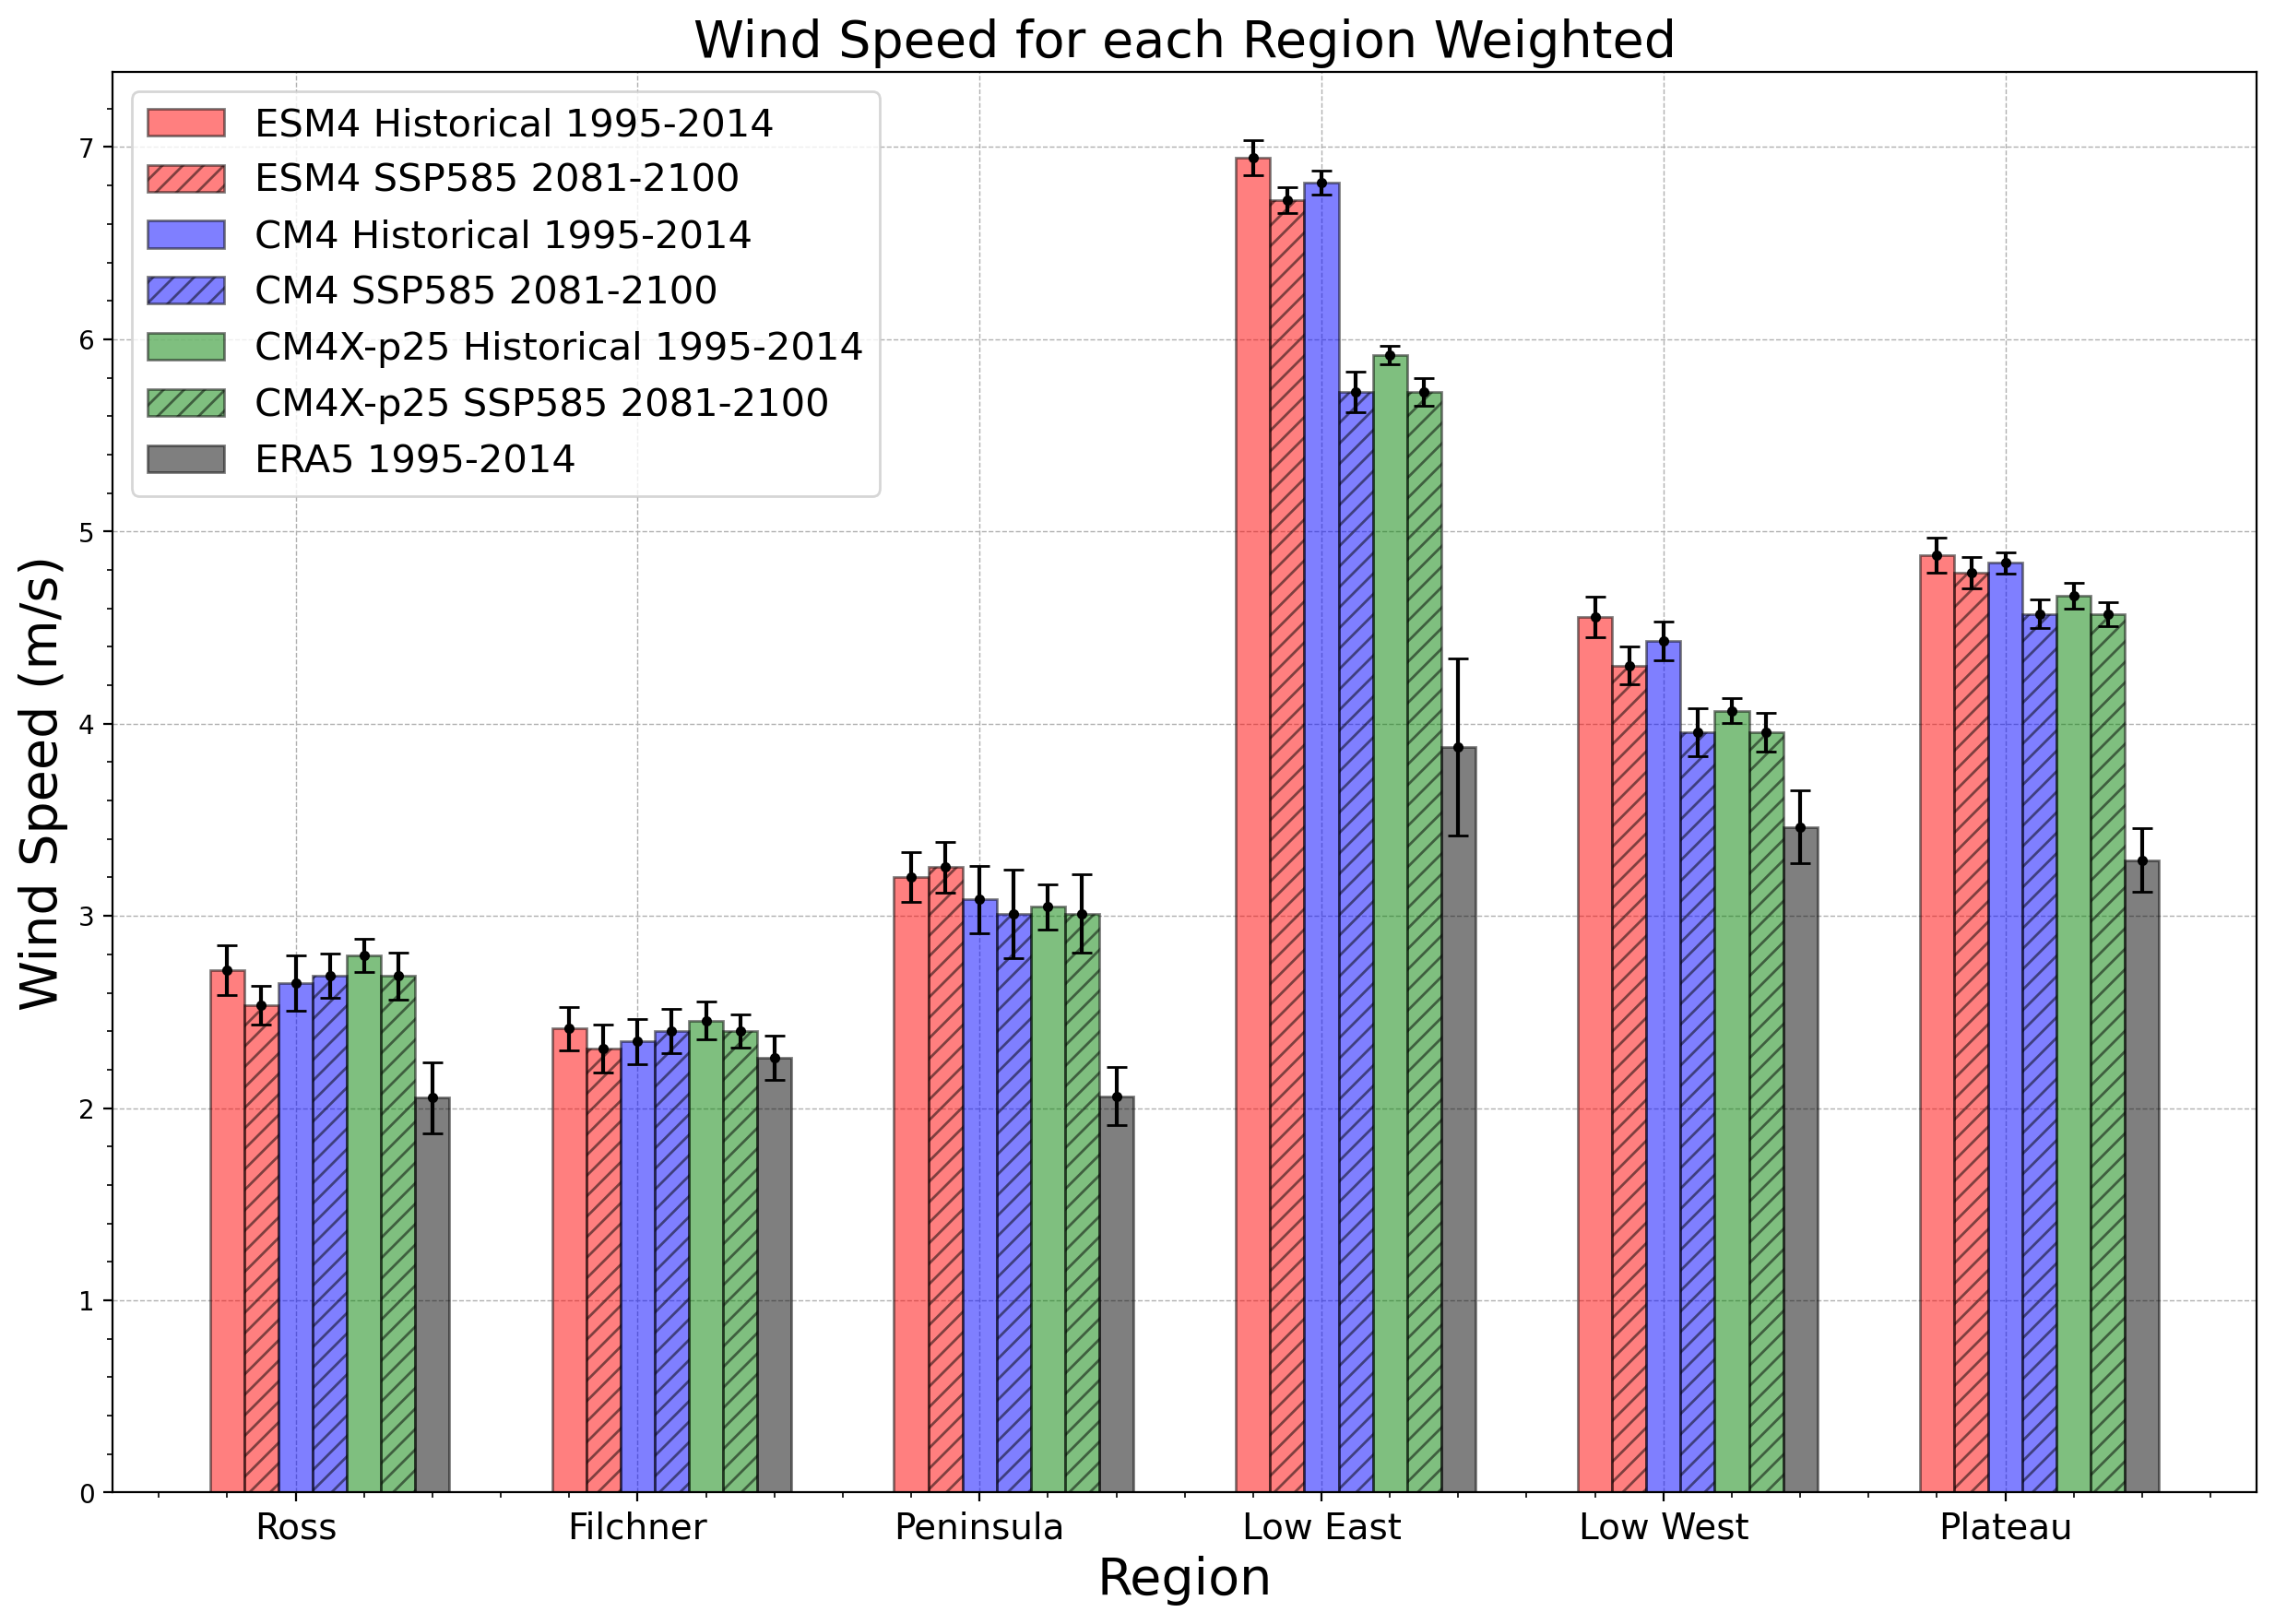

In [21]:
fig, ax= plt.subplots(figsize= (15,10))

X = ['Ross','Filchner','Peninsula','Low East', 'Low West', 'Plateau'] 
CM4_total = [2.652426617888736,
2.3462811863304864,
3.084939075764785,
6.816924915195285,
4.4290815037601075,
4.836539051129336] 

CM4_SSP585_total=[2.6883911524608126,
2.4005182851131757,
3.011193493951181,
5.726419567260154,
3.954811912334859,
4.571322007188408]

ESM4_total = [2.717323193980317,
2.413653711220919,
3.2008522669365895,
6.944507789949228,
4.556693396811866,
4.876263966612993] 

ESM4_SSP585_total=[2.535717458676808,
2.3090567137077205,
3.2539406470074943,
6.725562011401008,
4.303066327873063,
4.785620492882357]

ERA5_total = [2.0541219718707366,
2.261370707221682,
2.0622170744754036,
3.879573766002976,
3.4623717554675686,
3.290086151241666]

CM4X_total = [2.795495161565733,
2.4551558437181096,
3.046842730252119,
5.91763074811499,
4.067977060422126,
4.6643710997910235]

CM4X_SSP585_total=[2.6883911524608126,
2.4005182851131757,
3.011193493951181,
5.726419567260154,
3.954811912334859,
4.571322007188408]

std_cm4=[0.1438511021082609,
0.11699910524373235,
0.17684365396473753,
0.062112135475135284,
0.1008798676797807,
0.05667772602999289]

std_esm4=[0.12827888028683546,
0.1112760032392988,
0.1301968465953218,
0.0924209210316265,
0.10579032034074715,
0.09259222616016305]

std_era5= [0.1862190909768641,
0.11528699976409783,
0.15290147555709413,
0.46160155346448595,
0.18986837028166756,
0.16606948611360867]

std_cm4x = [0.08563159452774731,
0.09880345534111222,
0.11616729623324284,
0.04899005280025134,
0.06580244510510012,
0.06702133318191811]

std_cm4x_ssp585= [0.12284717596089571,
0.08617890230707151,
0.20461534667324466,
0.07259554082602682,
0.09949711868152591,
0.06288855821790354]

std_cm4_ssp585=[0.11389434406595947,
0.11476066759906209,
0.22906479869040142,
0.10447773416855707,
0.12380927350403437,
0.07577566260850681]

std_esm4_ssp585=[0.1000144089935089,
0.1248915851530563,
0.13183640937986196,
0.06691110632043928,
0.09639411977809959,
0.08259639956763354]


X_axis = np.arange(len(X)) 

plt.bar(X_axis-0.2, ESM4_total, 0.1, label = 'ESM4 Historical 1995-2014', color='r',edgecolor='black', alpha=0.5) 
plt.errorbar(X_axis-0.2, ESM4_total,yerr= std_esm4,fmt='o', color= 'black', markersize=3, capsize=4)

plt.bar(X_axis-0.1, ESM4_SSP585_total, 0.1, label= 'ESM4 SSP585 2081-2100', color ='r', edgecolor='black', alpha=0.5, hatch='///')
plt.errorbar(X_axis-0.1, ESM4_SSP585_total, yerr= std_esm4_ssp585, fmt='o', color='black', markersize=3, capsize=4)

plt.bar(X_axis, CM4_total, 0.1, label = 'CM4 Historical 1995-2014', color= 'blue',edgecolor='black', alpha=0.5) 
plt.errorbar(X_axis, CM4_total, yerr=std_cm4, fmt='o', color='black', markersize=3, capsize=4)

plt.bar(X_axis+0.1,CM4_SSP585_total, 0.1, label='CM4 SSP585 2081-2100', color='blue', edgecolor='black', alpha=0.5, hatch='///')
plt.errorbar(X_axis+0.1, CM4_SSP585_total, yerr= std_cm4_ssp585, fmt='o', color='black', markersize=3, capsize=4)

plt.bar(X_axis+0.2, CM4X_total, 0.1, label= 'CM4X-p25 Historical 1995-2014', color='green', alpha=0.5,edgecolor='black')
plt.errorbar(X_axis+0.2, CM4X_total, yerr=std_cm4x, fmt= 'o', color='black', markersize=3, capsize=4)

plt.bar(X_axis+0.3, CM4X_SSP585_total, 0.1, label='CM4X-p25 SSP585 2081-2100', color='green', edgecolor='black', alpha=0.5, hatch='///')
plt.errorbar(X_axis+0.3, CM4X_SSP585_total, yerr= std_cm4x_ssp585, fmt='o', color='black', markersize=3, capsize=4)

plt.bar(X_axis + 0.4, ERA5_total, 0.1, label= 'ERA5 1995-2014', color= 'k', edgecolor='black', alpha=0.5)
plt.errorbar(X_axis+0.4, ERA5_total, yerr=std_era5, fmt='o', color='black', markersize=3, capsize=4)



ax.grid(linewidth=0.5, linestyle= '--')
ax.set_axisbelow(True)
plt.xticks(X_axis, X, fontsize=14) 
plt.xlabel("Region", fontsize=20) 
plt.ylabel("Wind Speed (m/s)", fontsize=20 )
plt.title("Wind Speed for each Region Weighted", fontsize=20) 
plt.legend(fontsize=15) 
ax.minorticks_on()
plt.savefig('TemperatureHistoricalWeighted.png')